In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *
from collections import Counter
import numpy as np
import time

import pandas as pd
import geopandas as gpd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

import itertools as it

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
today = time.strftime("%Y-%m-%d")

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [3]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
client = gspread.authorize(creds)

mass_data = client.open("COVID-data-Massachusetts")
contact_data = mass_data.worksheet('contact_tracing')
city_data = mass_data.worksheet('town_data')
school_data = mass_data.worksheet('k12_schools')

contact_df = pd.DataFrame(contact_data.get_all_records(default_blank=np.nan))
city_df = pd.DataFrame(city_data.get_all_records(default_blank=np.nan))
school_df = pd.DataFrame(school_data.get_all_records(default_blank=np.nan))
school_df = school_df[['date','school_id','name',
                       'new_cases_students','new_cases_employee','details']].copy()

# contact_df.loc[contact_df['raw_new_clusters']=='','raw_new_clusters'] = np.nan
# contact_df.loc[contact_df['raw_new_cases']=='','raw_new_cases'] = np.nan
# contact_df.loc[contact_df['raw_new_contacts']=='','raw_new_contacts'] = np.nan
# contact_df.loc[contact_df['raw_total_cases']=='','raw_total_cases'] = np.nan
# contact_df.loc[contact_df['raw_total_contacts']=='','raw_total_contacts'] = np.nan

In [4]:
dat_shp = gpd.read_file('../../covid19-mobility/data/towns/').rename(columns={'TOWN':'city'})
city_df['city'] = city_df['city'].str.upper()

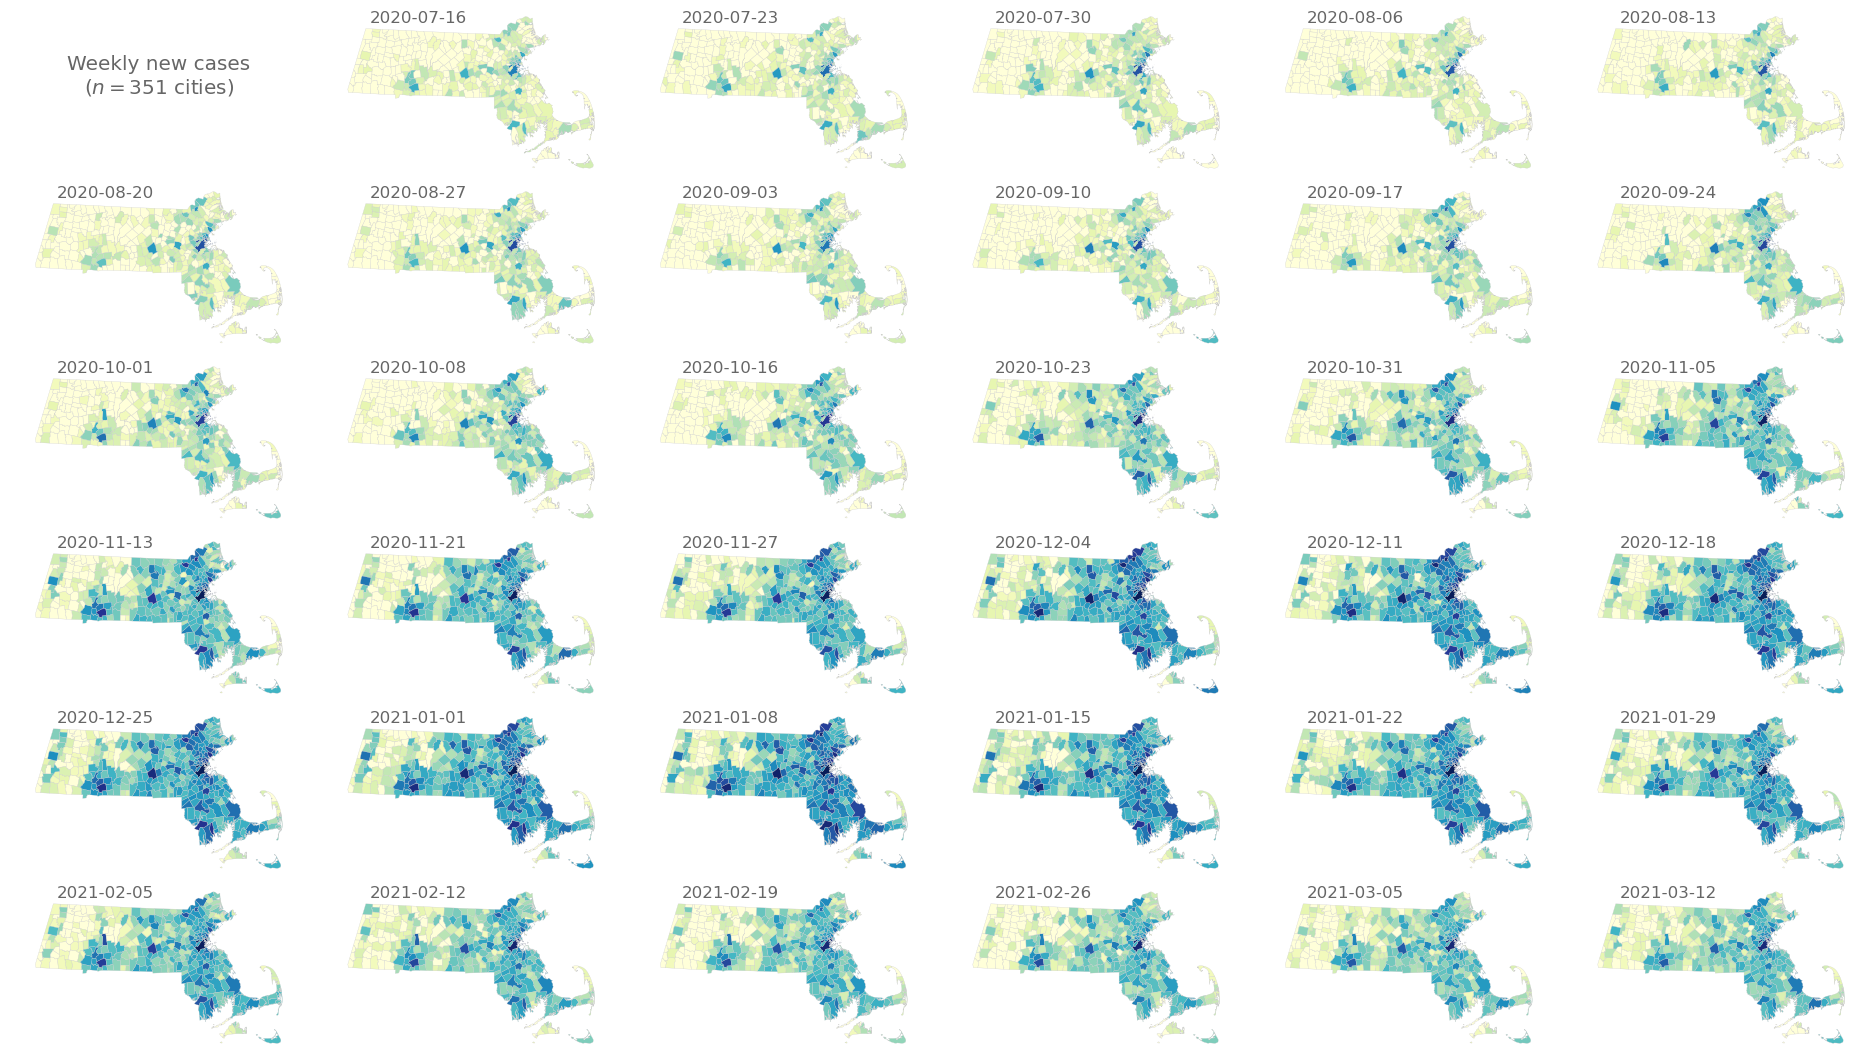

In [5]:
w = 4.0; h = 2.3
ncols = 6; nrows = 6
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, d in enumerate(list(city_df['date'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di != 0:
        aa = ax[tups[di]]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_df.loc[city_df['date']==d][['city','new_cases_town']],
                                    how='left', on='city')
        dat_shp_i['new_cases_town'] = np.log(dat_shp_i['new_cases_town']+1)
        dat_shp_i.plot(ax=aa, column='new_cases_town', ec='.8', lw=0.2, cmap='YlGnBu', vmin=0, vmax=7.5)
        aa.text(0.125, 0.95, d, ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')

    else:
        aa.text(0.5, 0.6, 'Weekly new cases\n($n=%i$ cities)'%city_df['city'].nunique(), color='.4',
                ha='center', va='center', transform=aa.transAxes, fontsize='x-large')

    aa.set_axis_off()

for dr in range(len(tups)-(di+1)):
    ax[tups[di + 1 + dr]].set_axis_off()


plt.savefig('../figs/pngs/ma_cities_casecounts_over_time.png',dpi=425,bbox_inches='tight')
plt.show()

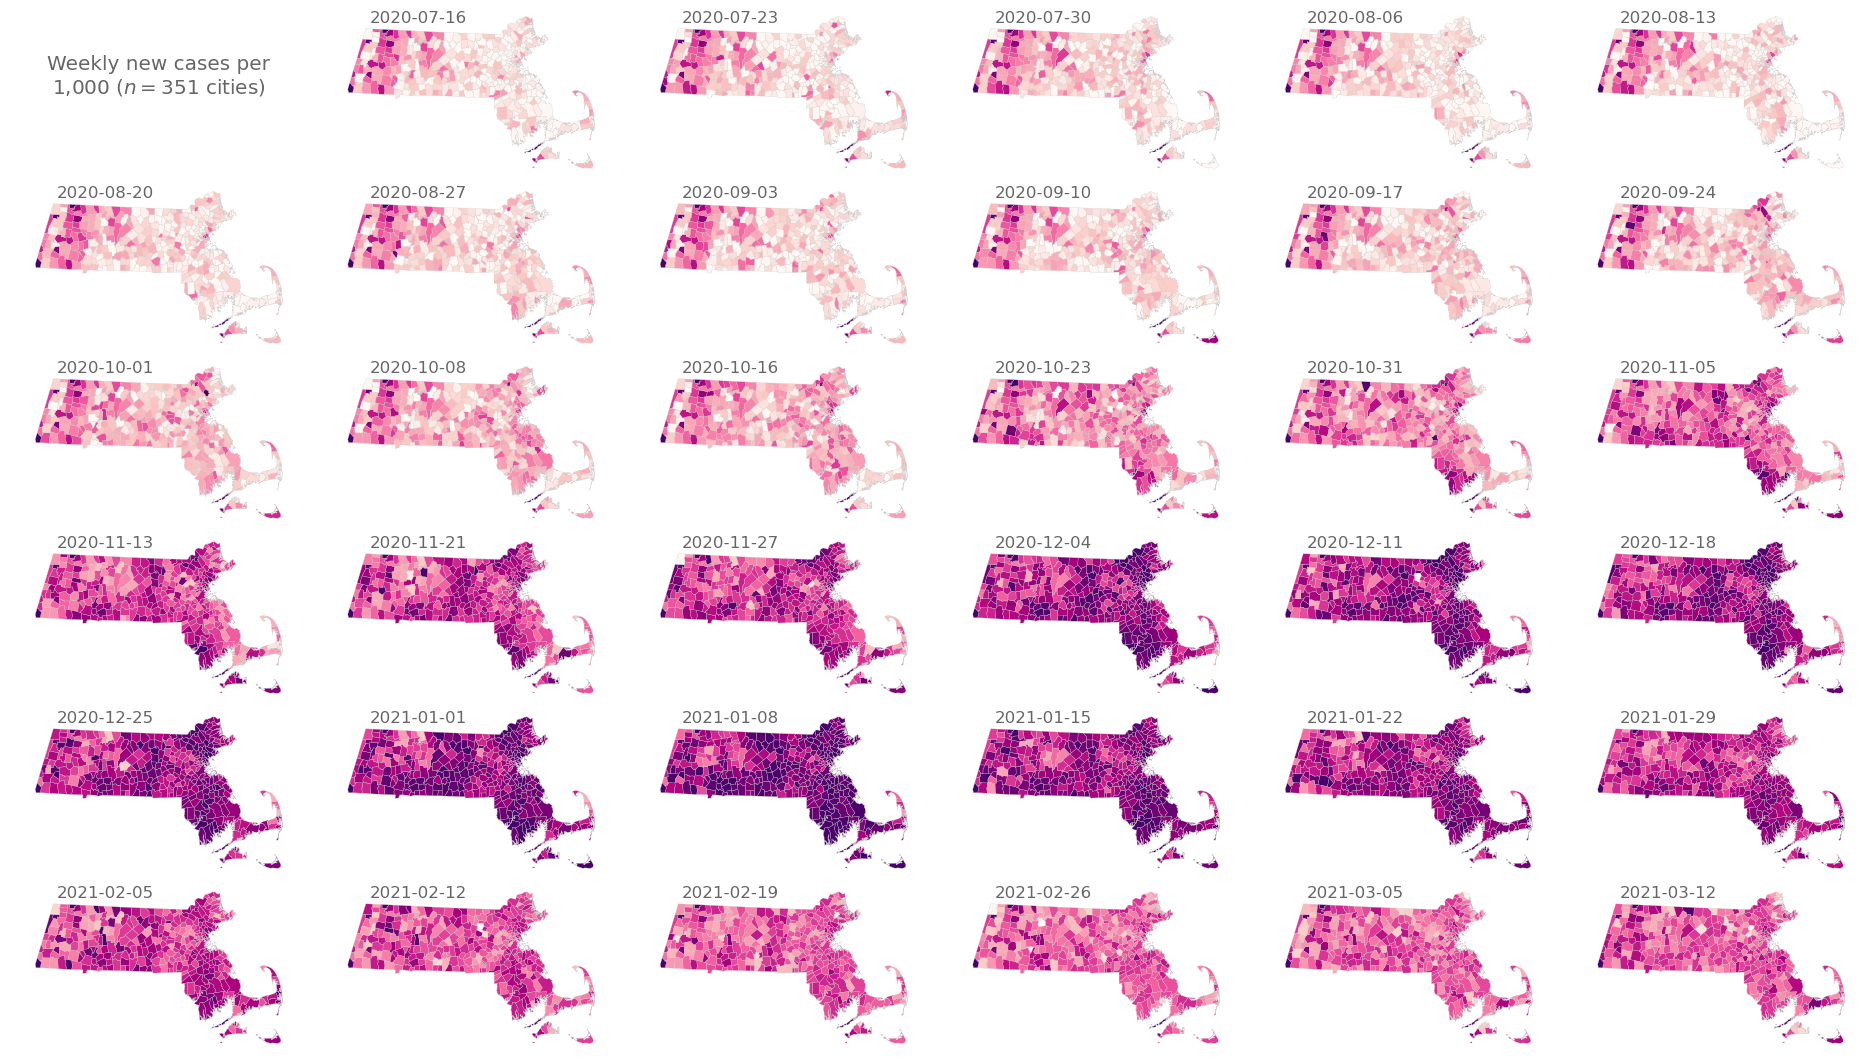

In [6]:
w = 4.0; h = 2.3
ncols = 6; nrows = 6
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, d in enumerate(list(city_df['date'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di != 0:
        aa = ax[tups[di]]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_df.loc[city_df['date']==d][['city','new_cases_town','population']],
                                    how='left', on='city')
        dat_shp_i['new_cases_town'] = np.log((dat_shp_i['new_cases_town']+1) / dat_shp_i['population'] * 1000)
        dat_shp_i.plot(ax=aa, column='new_cases_town', ec='.8', lw=0.2, cmap='RdPu', vmin=-2.0, vmax=2.0)
        aa.text(0.125, 0.95, d, ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')

    else:
        aa.text(0.5, 0.6, 'Weekly new cases per\n1,000 ($n=%i$ cities)'%city_df['city'].nunique(), color='.4',
                ha='center', va='center', transform=aa.transAxes, fontsize='x-large')

    aa.set_axis_off()

for dr in range(len(tups)-(di+1)):
    ax[tups[di + 1 + dr]].set_axis_off()

plt.savefig('../figs/pngs/ma_cities_casecounts_per1000_over_time.png',dpi=425,bbox_inches='tight')

plt.show()

In [7]:
widx = 3
city_dfx = []
for city in city_df['city'].unique():
    cf = city_df.loc[city_df['city']==city].copy()
    cf['new_cases_town'] = np.nan_to_num(cf['new_cases_town'].rolling(window=widx).mean())
    city_dfx.append(cf)
    
city_dfx = pd.concat(city_dfx).reset_index().iloc[:,1:]

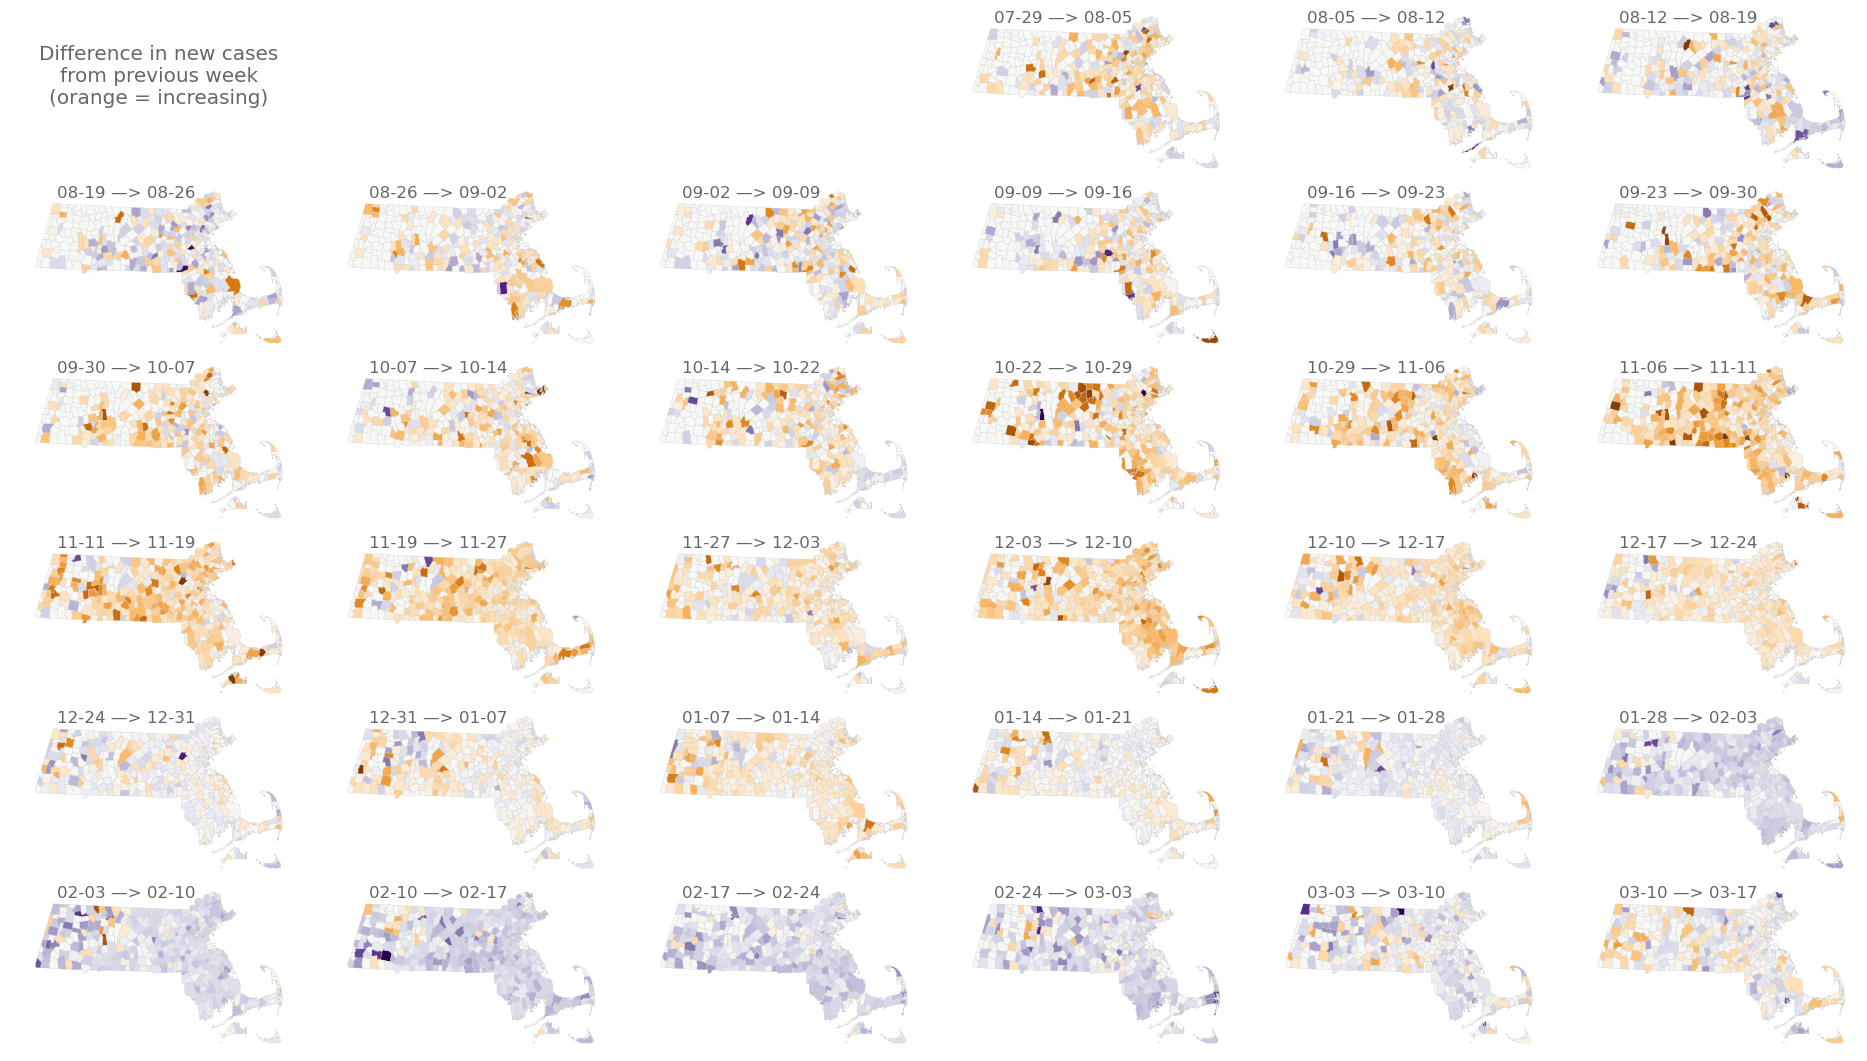

In [8]:
w = 4.0; h = 2.3
ncols = 6; nrows = 6
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, dcurr in enumerate(list(city_dfx['as_of'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di > widx-1:
        dprev = list(city_dfx['as_of'].unique())[-int(nrows*ncols):][di-1]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_dfx.loc[city_dfx['as_of']==dcurr][['city','new_cases_town']],
                        how='left', on='city').rename(columns={'new_cases_town':'new_cases_town_curr'})
        dat_shp_i['new_cases_town_curr'] = np.log(dat_shp_i['new_cases_town_curr']+1)
        dat_shp_i = dat_shp_i.merge(city_dfx.loc[city_dfx['as_of']==dprev][['city','new_cases_town']], 
                        how='left', on='city').rename(columns={'new_cases_town':'new_cases_town_prev'})
        dat_shp_i['new_cases_town_prev'] = np.log(dat_shp_i['new_cases_town_prev']+1)

        dat_shp_i['diff'] = dat_shp_i['new_cases_town_curr'] - dat_shp_i['new_cases_town_prev']

        dat_shp_i.plot(ax=aa, column='diff', ec='.8', lw=0.2, cmap='PuOr_r', vmin=-1.2, vmax=1.2)
        aa.text(0.125, 0.95, dprev[5:]+" —> "+dcurr[5:], ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')
    elif di == 0:
        aa.text(0.5, 0.6, 'Difference in new cases\nfrom previous week\n(orange = increasing)',
                ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='x-large')
        
    aa.set_axis_off()

for dr in range(len(tups)-(di+1)):
    ax[tups[di + 1 + dr]].set_axis_off()


plt.savefig('../figs/pngs/ma_cities_casecounts_over_time_diff.png',dpi=425,bbox_inches='tight')

plt.show()

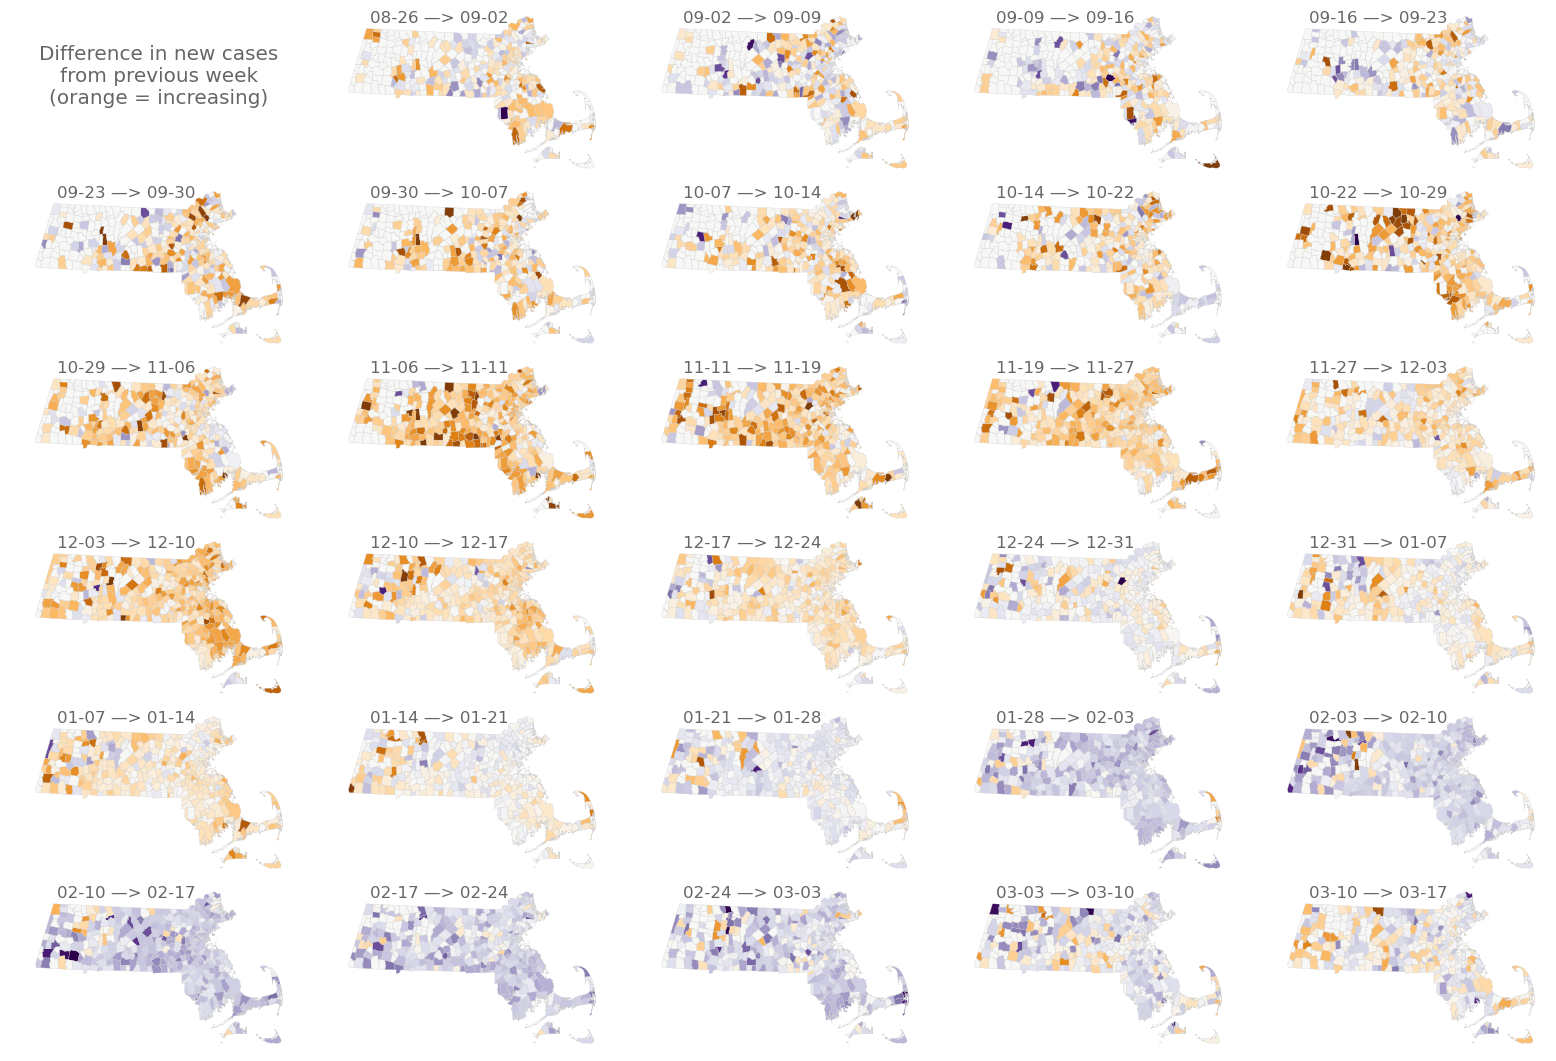

In [9]:
w = 4.0; h = 2.3
ncols = 5; nrows = 6
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, dcurr in enumerate(list(city_dfx['as_of'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di > 0:#widx-1:
        dprev = list(city_dfx['as_of'].unique())[-int(nrows*ncols):][di-1]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_dfx.loc[city_dfx['as_of']==dcurr][['city','new_cases_town']],
                        how='left', on='city').rename(columns={'new_cases_town':'new_cases_town_curr'})
        dat_shp_i['new_cases_town_curr'] = np.log(dat_shp_i['new_cases_town_curr']+1)
        dat_shp_i = dat_shp_i.merge(city_dfx.loc[city_dfx['as_of']==dprev][['city','new_cases_town']], 
                        how='left', on='city').rename(columns={'new_cases_town':'new_cases_town_prev'})
        dat_shp_i['new_cases_town_prev'] = np.log(dat_shp_i['new_cases_town_prev']+1)

        dat_shp_i['diff'] = dat_shp_i['new_cases_town_curr'] - dat_shp_i['new_cases_town_prev']

        dat_shp_i.plot(ax=aa, column='diff', ec='.8', lw=0.2, cmap='PuOr_r', vmin=-1.0, vmax=1.0)
        aa.text(0.125, 0.95, dprev[5:]+" —> "+dcurr[5:], ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')
    elif di == 0:
        aa.text(0.5, 0.6, 'Difference in new cases\nfrom previous week\n(orange = increasing)',
                ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='x-large')
        
    aa.set_axis_off()

for dr in range(len(tups)-(di+1)):
    ax[tups[di + 1 + dr]].set_axis_off()


plt.savefig('../figs/pngs/ma_cities_casecounts_over_time_diff2.png',dpi=425,bbox_inches='tight')

plt.show()

In [10]:
city_df['new_cases_per1000_town'] = city_df['new_cases_town'] / city_df['population'] * 1000

eligible_df = city_df.loc[(city_df['date']==city_df['date'].max())&\
                          (city_df['total_cases']>np.quantile(city_df['total_cases'],0.9))].copy()
rank_last4weeks = city_df.loc[(city_df['date'].isin(city_df['date'].unique()[-4:]))&\
                              (city_df['city'].isin(eligible_df['city'].values))].groupby('city').agg(
        {'new_cases_town':'mean'}).reset_index().sort_values('new_cases_town',ascending=False)

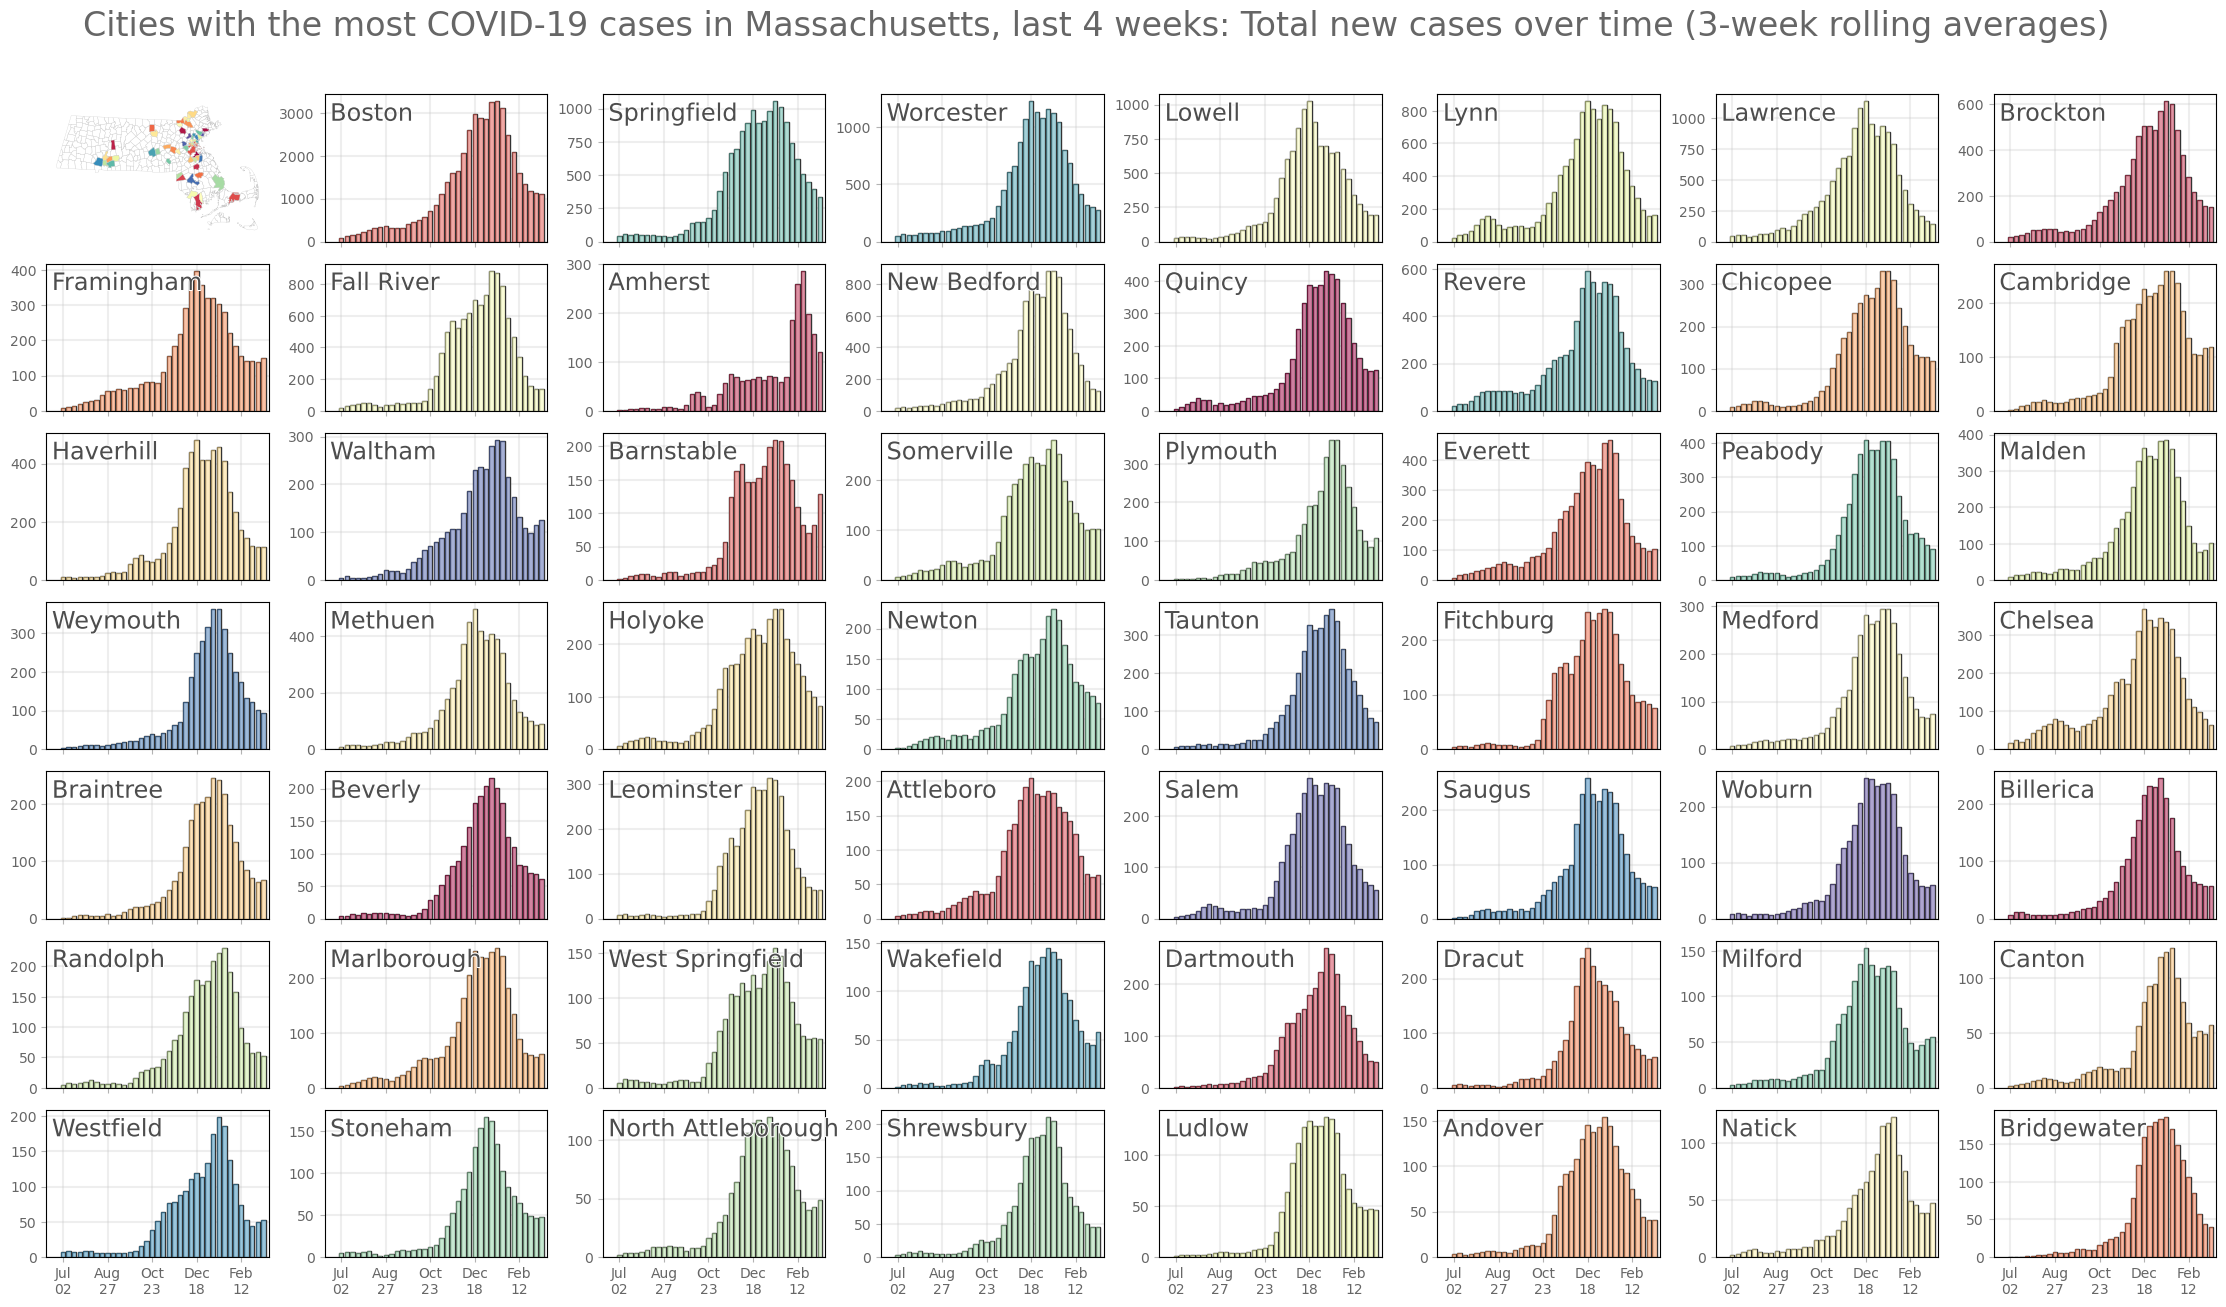

In [11]:
cmaa = plt.cm.Spectral

w = 3.5; h = 2.2
ncols = 8; nrows = 7
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.15)

dat_shp.plot(ax=ax[tups[0]], ec='.8', fc='none', lw=0.2)
dat_shp_i = dat_shp.loc[dat_shp['city'].isin(rank_last4weeks['city'].values[:(nrows*ncols)-1])].copy()
dat_shp_i = dat_shp_i.reset_index().iloc[:,1:]
dat_shp_i['col'] = list(range(dat_shp_i.shape[0]))
dat_shp_i.plot(ax=ax[tups[0]], ec='.8', lw=0.2, column='col', cmap=cmaa)
ax[tups[0]].set_axis_off()

cols = cmaa(dat_shp_i['col'].values/dat_shp_i['col'].max())
cols = dict(zip(dat_shp_i['city'].values,cols))

for ci, city_i in enumerate(rank_last4weeks['city'].values[:(nrows*ncols)-1]):
    aa = ax[tups[ci+1]]
    cti = city_df.loc[city_df['city']==city_i].copy()
    xvals_i = list(range(len(cti['new_cases_per1000_town'])))
    yvals_i = cti['new_cases_per1000_town'].values
    yvals_i = cti['new_cases_town'].rolling(window=3).mean().values
    aa.bar(xvals_i, yvals_i, fc='w', ec='.2')
    aa.bar(xvals_i, yvals_i, fc=cols[city_i], ec='none',alpha=0.5)

    title_i = " ".join([i.capitalize() for i in city_i.split(' ')])

    aa.text(0.025,0.95,title_i,ha='left',va='top',transform=aa.transAxes,fontsize='xx-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(cti['date'].nunique()))[2::8]])
    if tups[ci+1][0] == nrows-1:
        aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in cti['date'].unique()[2::8]])
        
    else:
        aa.set_xticklabels(['' for i in list(range(cti['date'].nunique()))[2::8]])
        
    aa.set_xlim(list(range(city_df['date'].nunique()))[0]-1,list(range(city_df['date'].nunique()))[-1]+1)

plt.suptitle('Cities with the most COVID-19 cases in Massachusetts, last 4 weeks: '+\
             'Total new cases over time (3-week rolling averages)', y=0.935, fontsize=24,
             color='.4')

plt.savefig('../figs/pngs/ma_cities_last4weeks_ranking.png',dpi=425,bbox_inches='tight')

plt.show()

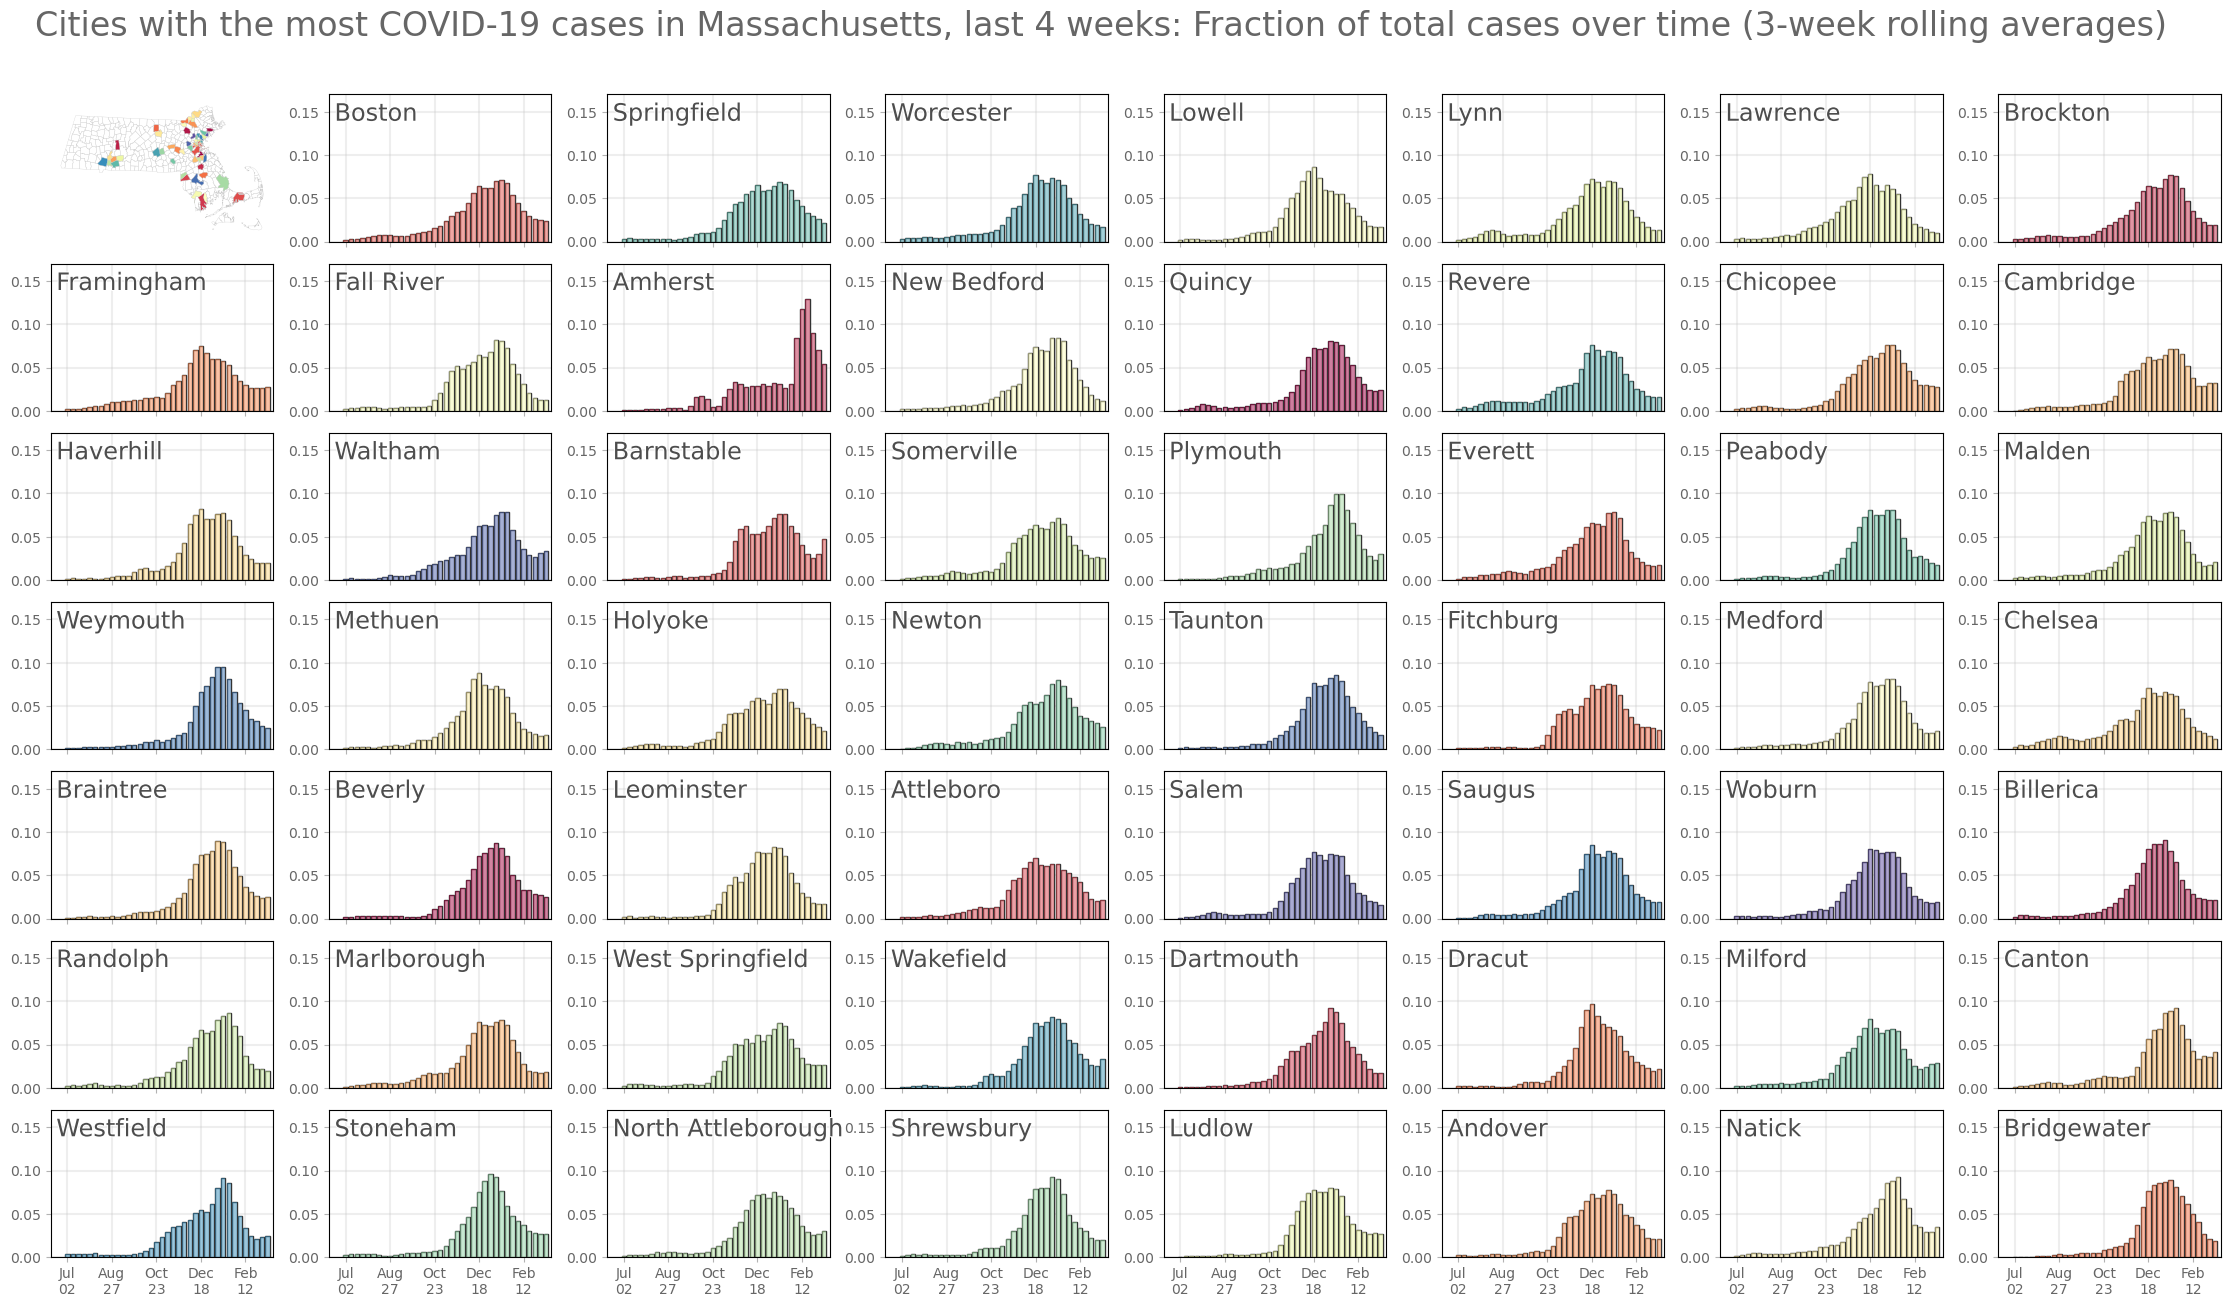

In [12]:
cmaa = plt.cm.Spectral

w = 3.5; h = 2.2
ncols = 8; nrows = 7
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.15)

dat_shp.plot(ax=ax[tups[0]], ec='.8', fc='none', lw=0.2)
dat_shp_i = dat_shp.loc[dat_shp['city'].isin(rank_last4weeks['city'].values[:(nrows*ncols)-1])].copy()
dat_shp_i = dat_shp_i.reset_index().iloc[:,1:]
dat_shp_i['col'] = list(range(dat_shp_i.shape[0]))
dat_shp_i.plot(ax=ax[tups[0]], ec='.8', lw=0.2, column='col', cmap=cmaa)
ax[tups[0]].set_axis_off()

cols = cmaa(dat_shp_i['col'].values/dat_shp_i['col'].max())
cols = dict(zip(dat_shp_i['city'].values,cols))

for ci, city_i in enumerate(rank_last4weeks['city'].values[:(nrows*ncols)-1]):
    aa = ax[tups[ci+1]]
    cti = city_df.loc[city_df['city']==city_i].copy()
    xvals_i = list(range(len(cti['new_cases_per1000_town'])))
    yvals_i = cti['new_cases_per1000_town'].values
    yvals_i = cti['new_cases_town'].rolling(window=3).mean().values
    yvals_i = yvals_i / np.nansum(yvals_i)
    aa.bar(xvals_i, yvals_i, fc='w', ec='.2')
    aa.bar(xvals_i, yvals_i, fc=cols[city_i], ec='none',alpha=0.5)

    title_i = " ".join([i.capitalize() for i in city_i.split(' ')])

    aa.text(0.025,0.95,title_i,ha='left',va='top',transform=aa.transAxes,fontsize='xx-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(cti['date'].nunique()))[2::8]])
    if tups[ci+1][0] == nrows-1:
        aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in cti['date'].unique()[2::8]])
        
    else:
        aa.set_xticklabels(['' for i in list(range(cti['date'].nunique()))[2::8]])
        

    aa.set_ylim(0, 0.17)
    aa.set_xlim(list(range(city_df['date'].nunique()))[0]-1,list(range(city_df['date'].nunique()))[-1]+1)

plt.suptitle('Cities with the most COVID-19 cases in Massachusetts, last 4 weeks: '+\
             'Fraction of total cases over time (3-week rolling averages)', y=0.935, fontsize=24,
             color='.4')

plt.savefig('../figs/pngs/ma_cities_last4weeks_ranking_frac.png',dpi=425,bbox_inches='tight')

plt.show()

In [13]:
heatm = []
city_order = city_df.loc[city_df['date']==city_df['date'].max()].sort_values('total_cases').city.values[::-1]
for ci, city_i in enumerate(city_order):
    cti = city_df.loc[city_df['city']==city_i].copy()
    yvals_i = cti['new_cases_per1000_town'].rolling(window=3).mean().values
    if sum(cti['new_cases_town'])>10:
        heatm.append(yvals_i)
    else:
        heatm.append(np.zeros(cti.shape[0]))

In [14]:
import cmocean as cmo

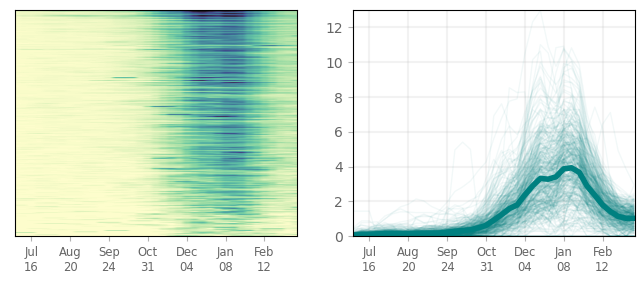

In [15]:
fig, ax = plt.subplots(1,2,figsize=(8,3),dpi=100)

ax[0].imshow(np.array(heatm),aspect='auto',vmin=0, vmax=10, cmap=cmo.cm.deep)
ax[1].plot(np.array(heatm).T, color='teal', alpha=0.05, lw=1)
ax[1].plot(np.mean(heatm,axis=0), color='teal', lw=4)
# ax.set_yticks(list(range(len(city_order)))[::10])
# ax.set_yticklabels(city_order[::10], fontsize='xx-small')
ax[0].set_yticks([])

ax[0].set_ylim(330,0)
ax[1].set_ylim(0,13)
ax[0].set_xlim(1.9,len(np.mean(heatm,axis=0))-0.85)
ax[1].set_xlim(1.9,len(np.mean(heatm,axis=0))-0.85)
ax[1].grid(linewidth=1.5,color='.75',alpha=0.2)
for a in fig.axes:
    a.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    a.set_xticks([i for i in list(range(cti['date'].nunique()))[4::5]])
    a.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in cti['date'].unique()[4::5]],fontsize='small')

plt.savefig('../figs/pngs/ma_heatmap_city_cases.png',dpi=425,bbox_inches='tight')

plt.show()

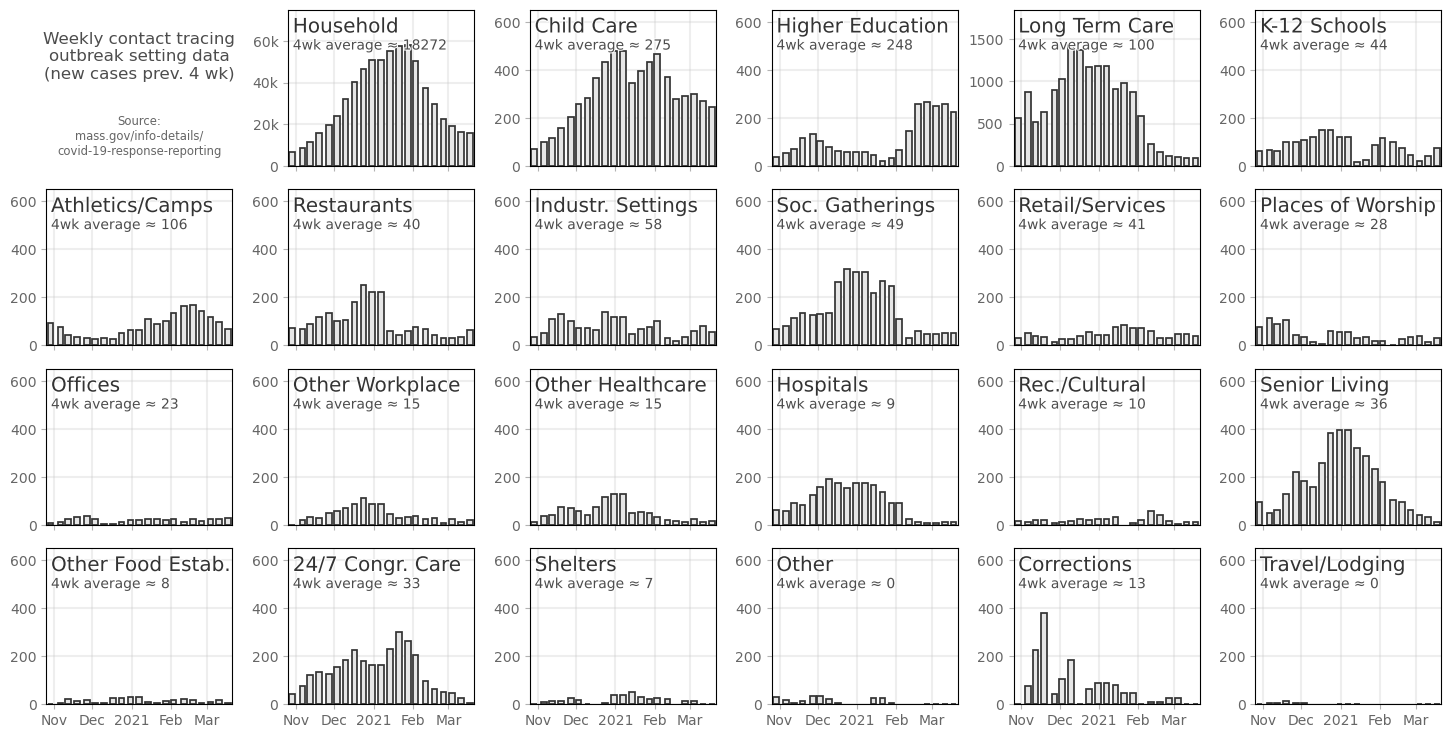

In [16]:
barw = 4.5
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congr. Care', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industr. Settings', 'K-12 Schools', 'Long Term Care',
       'Offices', 'Athletics/Camps', 'Other',
       'Other Food Estab.', 'Other Healthcare',
       'Other Workplace', 'Places of Worship', 'Rec./Cultural',
       'Restaurants', 'Retail/Services', 'Senior Living',
       'Shelters', 'Soc. Gatherings', 'Travel/Lodging']))

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01']
dates_ll = ['Nov','Dec','2021','Feb','Mar']

settings_order = contact_df.loc[contact_df['data_date']==contact_df['data_date'].max()\
                   ].sort_values('raw_new_cases',ascending=False)['setting'].unique()

for di, dcurr in enumerate(settings_order):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    aa.bar([date_dict[i] for i in cti['data_date']], cti['raw_new_cases'],
           fc='.9', ec='.2', width=barw, lw=1.25)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    four_wmean = np.nanmean(np.nan_to_num(cti['raw_new_cases'].values)[-4:])
    aa.text(0.025,0.815,'4wk average ≈ %i'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict[contact_df['data_date'].min()]-barw/2-1,
                date_dict[contact_df['data_date'].max()]+barw/2+1)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.25)

    if labs[dcurr]=='Household':
        aa.set_ylim(0, 75000)
        aa.set_yticks([0, 20000, 40000, 60000])
        aa.set_yticklabels(['0', '20k', '40k', '60k'])
    elif labs[dcurr]=='Long Term Care':
        aa.set_ylim(0, 1850)
        aa.set_yticks([0, 500, 1000, 1500])
    else:
        aa.set_ylim(0, 650)
        aa.set_yticks([0, 200, 400, 600])


aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases prev. 4 wk)',
        ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newcases_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_outbreak_settings_newcases_all.pdf',bbox_inches='tight')

plt.show()

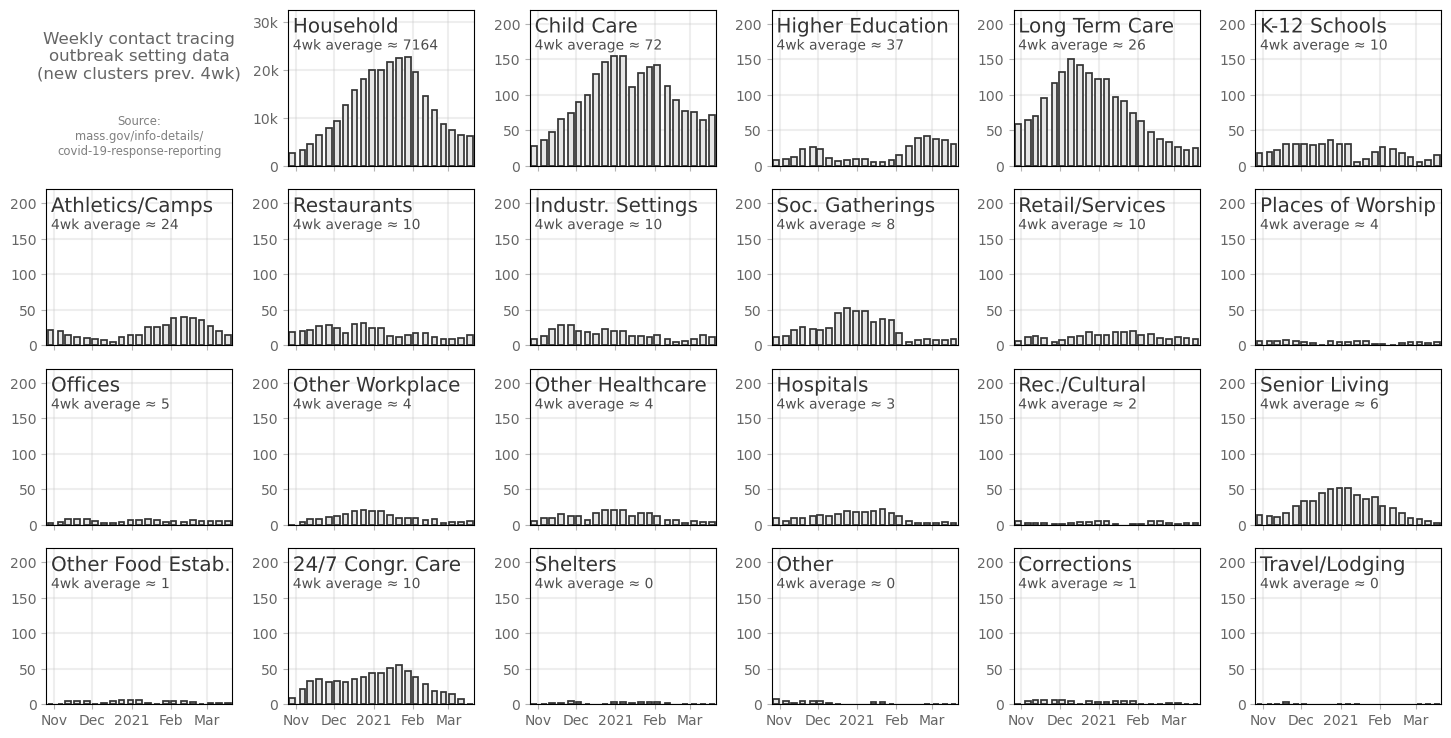

In [17]:
barw = 4.5
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congr. Care', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industr. Settings', 'K-12 Schools', 'Long Term Care',
       'Offices', 'Athletics/Camps', 'Other',
       'Other Food Estab.', 'Other Healthcare',
       'Other Workplace', 'Places of Worship', 'Rec./Cultural',
       'Restaurants', 'Retail/Services', 'Senior Living',
       'Shelters', 'Soc. Gatherings', 'Travel/Lodging']))

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01']
dates_ll = ['Nov','Dec','2021','Feb','Mar']
settings_order = contact_df.loc[contact_df['data_date']==contact_df['data_date'].max()\
                   ].sort_values('raw_new_cases',ascending=False)['setting'].unique()

for di, dcurr in enumerate(settings_order):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    aa.bar([date_dict[i] for i in cti['data_date']], cti['raw_new_clusters'],
           fc='.9', ec='.2', width=barw, lw=1.25)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    four_wmean = np.nanmean(np.nan_to_num(cti['raw_new_clusters'].values)[-4:])
    aa.text(0.025,0.815,'4wk average ≈ %i'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict[contact_df['data_date'].min()]-barw/2-1,
                date_dict[contact_df['data_date'].max()]+barw/2+1)

    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.35)

    if labs[dcurr]=='Household':
        aa.set_ylim(0, 32500)
        aa.set_yticks([0, 10000, 20000, 30000])
        aa.set_yticklabels(['0', '10k', '20k', '30k'])
    else:
        aa.set_ylim(0, 220)



aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new clusters prev. 4wk)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newclusters_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_outbreak_settings_newclusters_all.pdf',bbox_inches='tight')

plt.show()

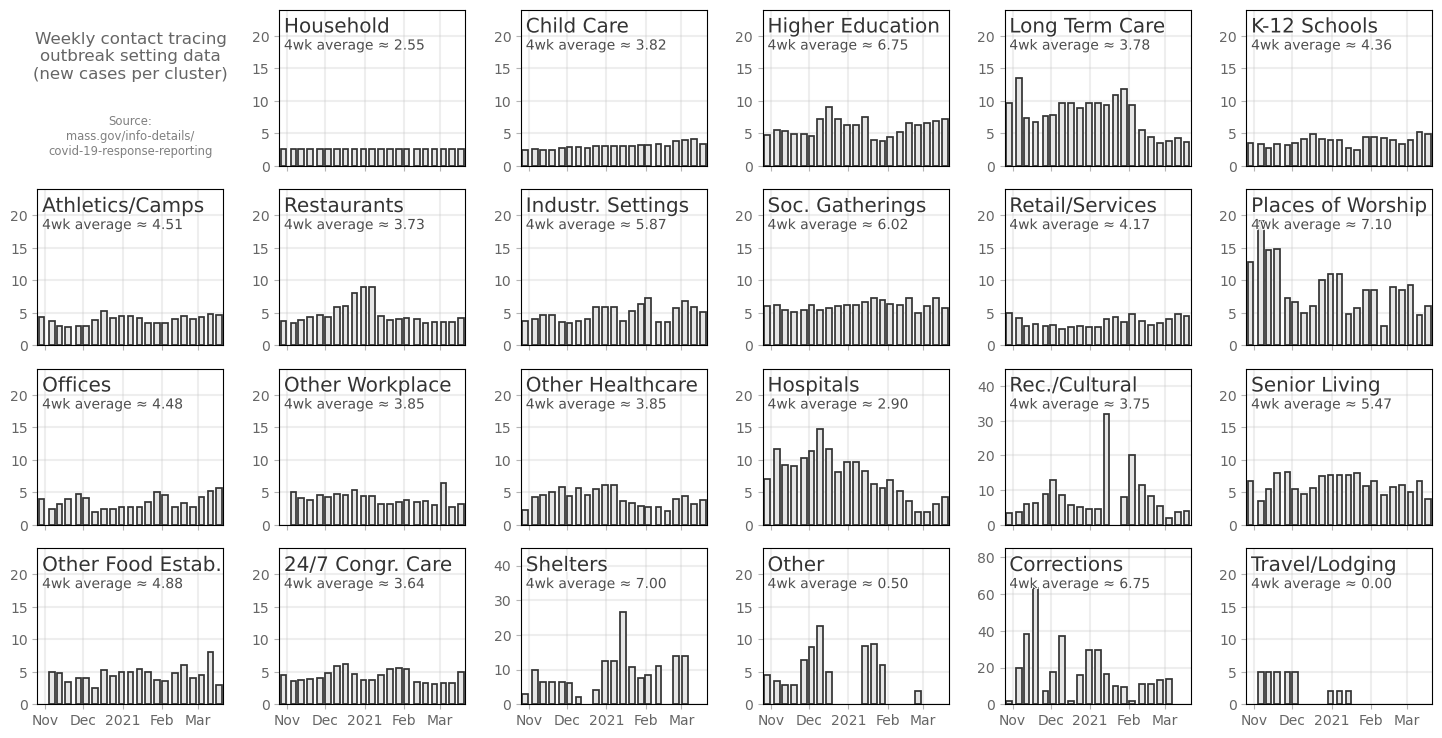

In [18]:
barw = 4.5
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congr. Care', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industr. Settings', 'K-12 Schools', 'Long Term Care',
       'Offices', 'Athletics/Camps', 'Other',
       'Other Food Estab.', 'Other Healthcare',
       'Other Workplace', 'Places of Worship', 'Rec./Cultural',
       'Restaurants', 'Retail/Services', 'Senior Living',
       'Shelters', 'Soc. Gatherings', 'Travel/Lodging']))

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01']
dates_ll = ['Nov','Dec','2021','Feb','Mar']
settings_order = contact_df.loc[contact_df['data_date']==contact_df['data_date'].max()\
                   ].sort_values('raw_new_cases',ascending=False)['setting'].unique()

for di, dcurr in enumerate(settings_order):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti['raw_new_cases_per'] = cti['raw_new_cases']/cti['raw_new_clusters']
    aa.bar([date_dict[i] for i in cti['data_date']], cti['raw_new_cases_per'],
           fc='.9', ec='.2', width=barw, lw=1.25)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict[contact_df['data_date'].min()]-barw/2-1,
                date_dict[contact_df['data_date'].max()]+barw/2+1)

    four_wmean = np.nanmean(np.nan_to_num(cti['raw_new_cases_per'].values)[-4:])
    aa.text(0.025,0.815,'4wk average ≈ %.2f'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    if labs[dcurr]=='Corrections':
        aa.set_ylim(0, 85)
    elif labs[dcurr] in ['Rec./Cultural','Shelters']:
        aa.set_ylim(0, 45)
    else:
        aa.set_ylim(0, 24)

aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases per cluster)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')
aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newcases_per_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_outbreak_settings_newcases_per_all.pdf',bbox_inches='tight')

plt.show()

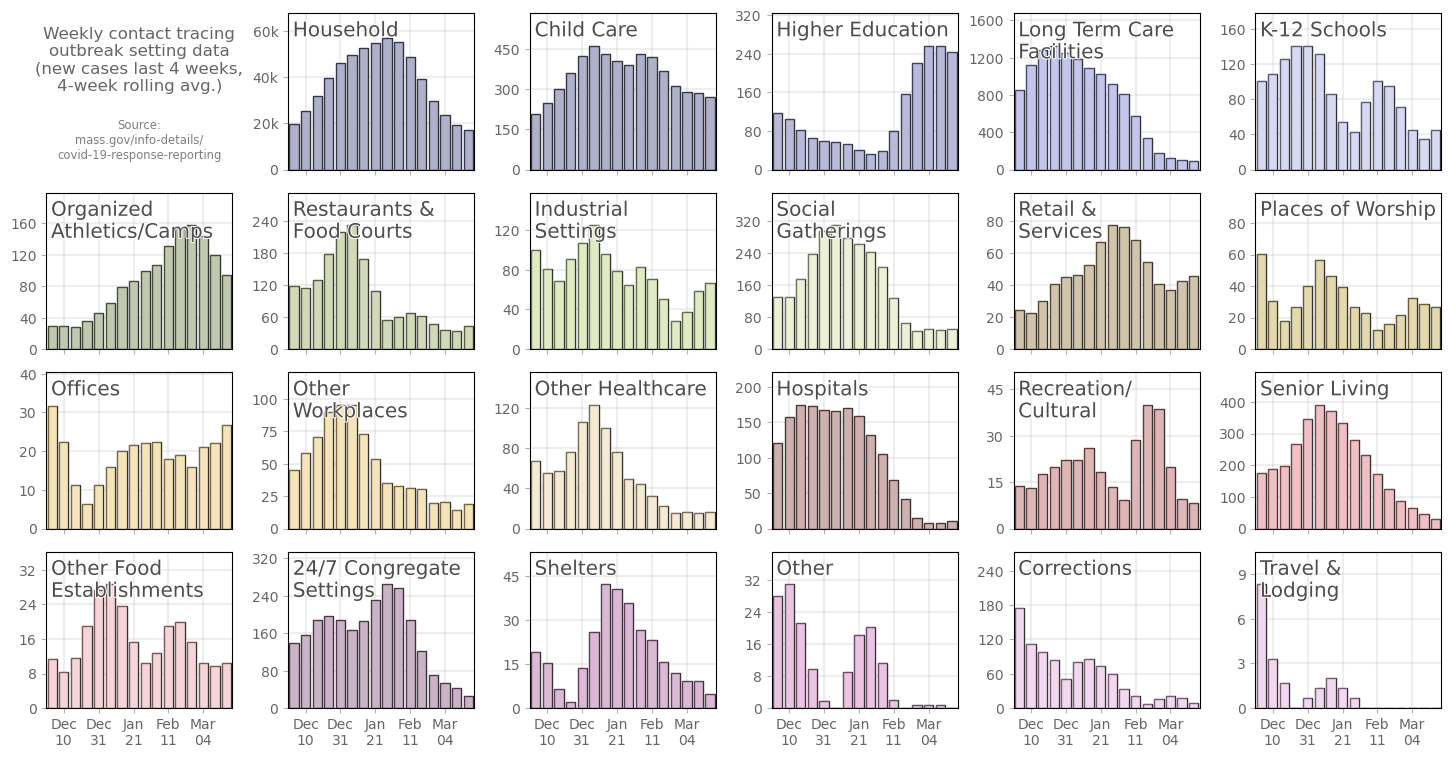

In [19]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.loc[contact_df['data_date']==contact_df['data_date'].max()\
                           ].sort_values('raw_new_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti.loc[cti['raw_new_cases']=='','raw_new_cases'] = 0
    cti.loc[cti['raw_new_cases'].isna(),'raw_new_cases'] = 0
    cti['raw_new_cases'] = cti['raw_new_cases'].rolling(window=3).mean()
    aa.bar(list(range(len(cti['raw_new_cases'])-4)),cti['raw_new_cases'].values[4:],fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases'])-4)),cti['raw_new_cases'].values[4:],fc=cols[di-1],
           ec='none',alpha=0.4)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()-4))[2::3]])
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[6::3]])
    xlimx = max(list(range(len(cti['raw_new_cases']))))-3.5
    aa.set_xlim(0.5,xlimx)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.2)

    if di == 1:
        aa.set_ylim(0, 67500)
        aa.set_yticks([0, 20000, 40000, 60000])
        aa.set_yticklabels(['0', '20k', '40k', '60k'])



aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases last 4 weeks,\n4-week rolling avg.)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newcases.png',dpi=425,bbox_inches='tight')

plt.show()

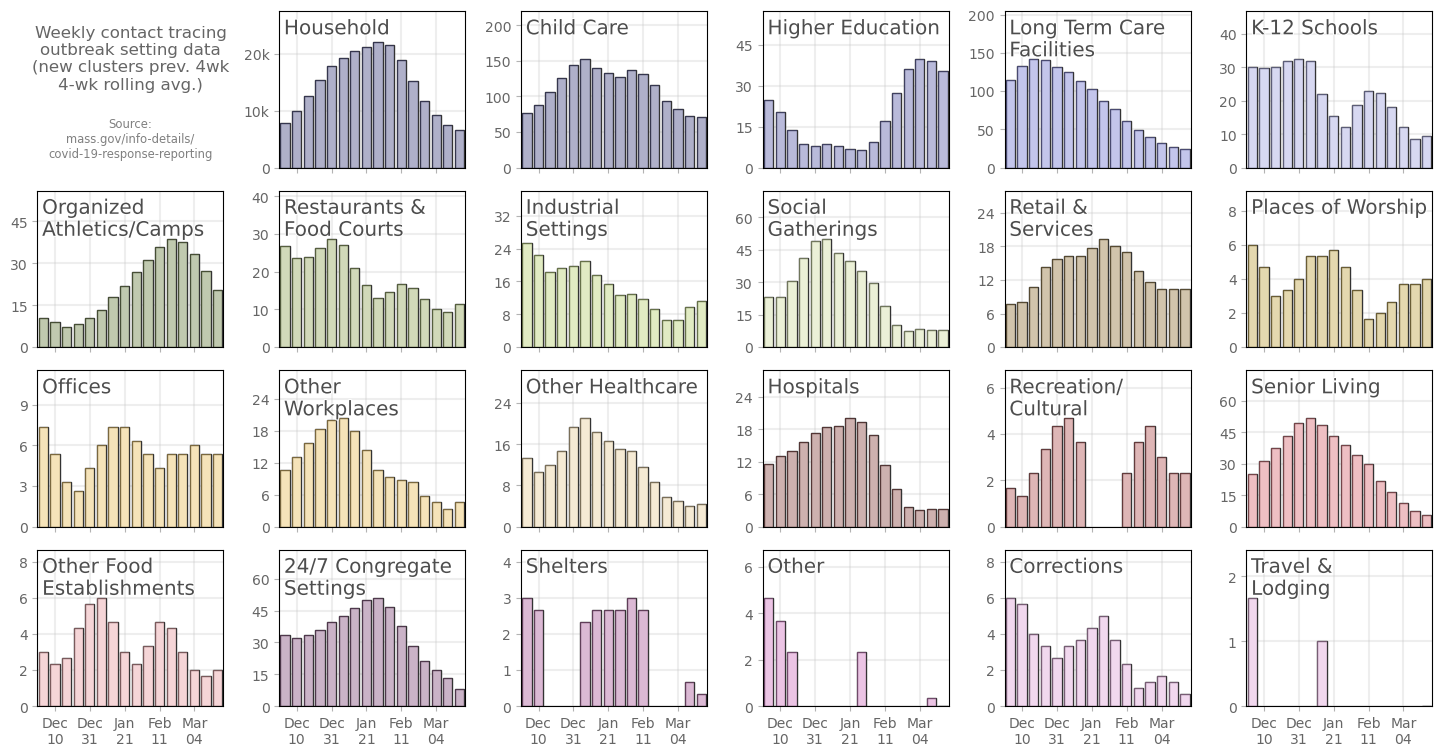

In [20]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.loc[contact_df['data_date']==contact_df['data_date'].max()\
                           ].sort_values('raw_new_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti.loc[cti['raw_new_clusters']=='','raw_new_clusters'] = 0
    cti['raw_new_clusters'] = cti['raw_new_clusters'].rolling(window=3).mean()
    aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc=cols[di-1],
           ec='none',alpha=0.4)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[::3]])
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[::3]])
    xlimx = max(list(range(len(cti['raw_new_cases']))))+0.5
    aa.set_xlim(4.5,xlimx)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.375)

    if di == 1:
        aa.set_ylim(0, 27500)
        aa.set_yticks([0, 10000, 20000])
        aa.set_yticklabels(['0', '10k', '20k'])



aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new clusters prev. 4wk\n4-wk rolling avg.)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')

# aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (new clusters\nprev. 4 weeks)',
#         ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')

aa.set_axis_off()


plt.savefig('../figs/pngs/ma_outbreak_settings_newclusters.png',dpi=425,bbox_inches='tight')

plt.show()

In [21]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.loc[contact_df['data_date']==contact_df['data_date'].max()\
                           ].sort_values('raw_new_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti.loc[cti['raw_new_clusters']=='','raw_new_clusters'] = 0
    cti.loc[cti['raw_new_cases']=='','raw_new_cases'] = 0
    cti['raw_new_cases'] = np.nan_to_num(cti['raw_new_cases'].rolling(window=2).mean())+1e-8
    cti['raw_new_clusters'] = np.nan_to_num(cti['raw_new_clusters'].rolling(window=2).mean())+1e-8
#     cti['raw_new_cases_per'] = cti['raw_new_cases'] / cti['raw_new_clusters']
    cti['raw_new_cases_per'] = np.nan_to_num(cti['raw_new_cases']) / np.nan_to_num(cti['raw_new_clusters'])
    cti['raw_new_cases_per'] = np.nan_to_num(cti['raw_new_cases_per'].rolling(window=4).mean())
#     cti['raw_new_cases_per'] = cti['raw_new_cases'] / cti['raw_new_clusters'].rolling(window=2).mean()
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases_per'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases_per'].values,fc=cols[di-1],
           ec='none',alpha=0.4)

    aa.text(0.025,0.95,labs[dcurr],
            ha='left', va='top',transform=aa.transAxes, fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    ym = 0.815
    if "\n" in labs[dcurr]:
        ym = 0.675
    aa.text(0.025,ym,'4wk $average=%.2f$'%(np.mean(cti['raw_new_cases_per'].dropna().values[-4:])),
#     aa.text(0.025,ym,'$average=%.1f$'%(cti['raw_new_cases_per'].dropna().mean()),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    xlimx = max(list(range(len(cti['raw_new_cases']))))+0.5

    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[::3]])
    if labs[dcurr] == 'Corrections':
        aa.set_ylim(0, 39)
    else:
        aa.set_ylim(0, 18)
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[::3]])
    aa.set_xlim(4.5,xlimx)


aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases per cluster,\n4-week rolling avg.)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newcases_per.png',dpi=425,bbox_inches='tight')

plt.show()

# vulnerable or older populations

In [22]:
temp = contact_df.loc[contact_df['setting'].isin(['Other Healthcare','Hospitals'])].copy()
gbcols = ['data_date', 'start_date', 'end_date']
agcols = ['raw_new_clusters', 'raw_new_cases', 'raw_new_contacts',
          'raw_total_clusters', 'raw_total_cases', 'raw_total_contacts']
temp = temp.groupby(gbcols).agg({i:'sum' for i in agcols}).reset_index()
temp['setting'] = 'Hospitals & Other Healthcare'
temp = temp[gbcols+['setting']+agcols]

In [23]:
contact_dfx = pd.concat([contact_df,temp]).reset_index().iloc[:,1:]

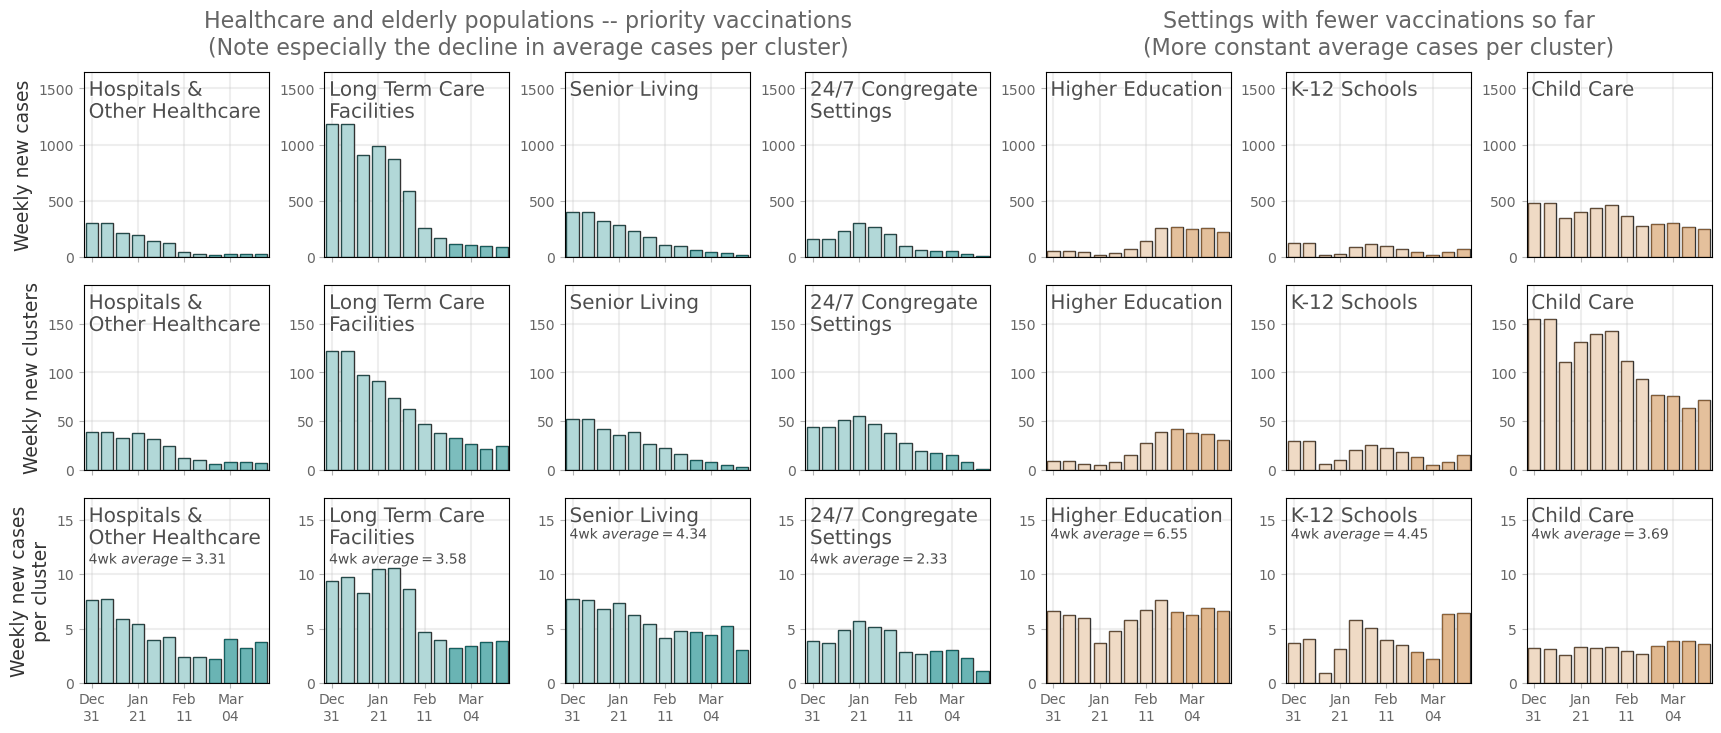

In [24]:
w = 3.0; h = 2.7
ncols = 7; nrows = 3
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

labs = dict(zip(['Hospitals & Other Healthcare', 'Long Term Care Facilities', 'Senior Living',
                 '24/7 Congregate Settings', 'Colleges & Universities', 'K-12 Schools', 'Child Care'],
                ['Hospitals &\nOther Healthcare', 'Long Term Care\nFacilities', 'Senior Living',
                 '24/7 Congregate\nSettings', 'Higher Education', 'K-12 Schools', 'Child Care']))

ncats = len(labs.keys())
cols = plt.cm.tab20b(np.linspace(0,1,ncats))
cols = ['teal']*4 + ['peru']*3
for di, dcurr in enumerate(list(labs.keys())):
    fci = cols[di]
    aa = ax[tups[di]]
    cti = contact_dfx.loc[contact_dfx['setting']==dcurr].copy()
    cti.loc[cti['raw_new_cases']=='','raw_new_cases'] = 0
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc=fci,
           ec='none',alpha=0.3)
    aa.bar(list(range(len(cti['raw_new_cases'])))[-4:],cti['raw_new_cases'].values[-4:],fc=fci,
           ec='none',alpha=0.3)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

xlimx = max(list(range(len(cti['raw_new_cases']))))+0.5
dn = di

for di, dcurr in enumerate(list(labs.keys())):
    fci = cols[di]
    di += dn + 1
    aa = ax[tups[di]]
    cti = contact_dfx.loc[contact_dfx['setting']==dcurr].copy()
    aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc=fci,
           ec='none',alpha=0.3)
    aa.bar(list(range(len(cti['raw_new_clusters'])))[-4:],cti['raw_new_clusters'].values[-4:],fc=fci,
           ec='none',alpha=0.3)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    
dn = di

for di, dcurr in enumerate(list(labs.keys())):
    fci = cols[di]
    di += dn + 1
    aa = ax[tups[di]]
    cti = contact_dfx.loc[contact_dfx['setting']==dcurr].copy()
    cti['raw_new_cases_per'] = cti['raw_new_cases'] / cti['raw_new_clusters'].rolling(window=2).mean()
    aa.bar(list(range(len(cti['raw_new_cases_per']))),cti['raw_new_cases_per'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases_per']))),cti['raw_new_cases_per'].values,fc=fci,
           ec='none',alpha=0.3)
    aa.bar(list(range(len(cti['raw_new_cases_per'])))[-4:],cti['raw_new_cases_per'].values[-4:],fc=fci,
           ec='none',alpha=0.4)

    aa.text(0.025,0.95,labs[dcurr],
            ha='left', va='top',transform=aa.transAxes, fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    ym = 0.85
    if "\n" in labs[dcurr]:
        ym = 0.715
    aa.text(0.025,ym,'4wk $average=%.2f$'%(np.mean(cti['raw_new_cases_per'].dropna().values[-4:])),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])


for ai, a in enumerate(fig.axes):
    a.set_xticks([i for i in list(range(contact_dfx['data_date'].nunique()))[::3]])
    a.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_dfx['data_date'].unique()[::3]])
    a.set_xlim(8.5, xlimx)
    a.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    ylims = a.get_ylim()
    ydiff = ylims[1] - ylims[0]
    a.set_ylim(ylims[0], ylims[1]+ydiff*0.32)
    if ai < 7:
        a.set_ylim(0, 1650)
    elif ai >= 7 and ai < 14:
        a.set_ylim(0, 190)
    else:
        a.set_ylim(0, 17)


ax[(0,0)].set_ylabel('Weekly new cases', color='.2', fontsize=13.5)
ax[(1,0)].set_ylabel('Weekly new clusters', color='.2', fontsize=13.5)
ax[(2,0)].set_ylabel('Weekly new cases\nper cluster', color='.2', fontsize=13.5)
ax[(0,2)].set_title('Healthcare and elderly populations -- priority vaccinations\n'+\
                    '(Note especially the decline in average cases per cluster)',
                    color='.4', fontsize=16, y=1.05, x=-0.2)
ax[(0,5)].set_title('Settings with fewer vaccinations so far\n(More constant average cases per cluster)',
                    color='.4', fontsize=16, y=1.05)

plt.savefig('../figs/pngs/vaccination_vs_nonvaccination.png',dpi=425,bbox_inches='tight')

plt.show()

# Hospitalization

In [34]:
hospx

collection_week state                           hospital_name  \
0           2021-03-05    PR             Hospital Industrial C.F.S.E   
1           2021-03-05    NV                    Elite Medical Center   
2           2021-03-05    PR   Centro Medico Correccional de Bayamon   
3           2021-03-05    LA           Alexandria Emergency Hospital   
4           2021-03-05    LA           Crescent City Surgical Centre   
...                ...   ...                                     ...   
159372      2020-07-31    PR    HOSPITAL METROPOLITANO DE LA MONTANA   
159373      2020-07-31    PR           CENTRO MEDICO WILMA N VAZQUEZ   
159374      2020-07-31    PR   HOSPITAL METROPOLITANO DR TITO MATTEI   
159375      2020-07-31    VI  GOV JUAN F LUIS HOSPITAL & MEDICAL CTR   
159376      2020-07-31    VI       ROY LESTER SCHNEIDER HOSPITAL,THE   

              city    zip fips_code  
0         San Juan  00935       NaN  
1        Las Vegas  89109       NaN  
2              NaN  00960       NaN  
3       Alexandria  71303       NaN  
4              NaN  70118       NaN  
...            ...    ...       ...  
159372   BDA NUEVA  00641     72141  
159373   VEGA BAJA  00693     72145  
159374       YAUCO  00698     72153  
159375    ST CROIX  00820     78010  
159376   ST THOMAS  00801     78020  

[159377 rows x 6 columns]

In [25]:
# # https://healthdata.gov/dataset/covid-19-reported-patient-impact-and-hospital-capacity-facility
# date = '20210314'
# date = '20210307'
# fn = 'https://healthdata.gov/sites/default/files/'+\
#       'reported_hospital_capacity_admissions_facility_level_weekly_average_timeseries_%s.csv'%date

# hosp = pd.read_csv(fn, dtype={'fips_code':str,'zip':str})
hosp_fn = 'https://healthdata.gov/api/views/anag-cw7u/rows.csv?accessType=DOWNLOAD'
hosp = pd.read_csv(hosp_fn, dtype={'fips_code':str,'zip':str})
hosp['collection_week'] = hosp.collection_week.astype(str).str[0:4] + '-' +\
                          hosp.collection_week.astype(str).str[5:7] + '-' +\
                          hosp.collection_week.astype(str).str[-2:]
hospx = hosp[['collection_week','state','hospital_name',
              'city','zip','fips_code']].copy()

In [26]:
adult_col = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'
child_col = 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'
nrep = 500

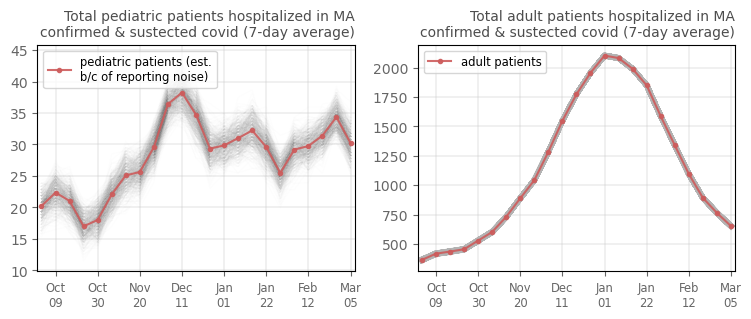

In [27]:
st = 'MA'
fig, ax = plt.subplots(1,2,figsize=(9,3),dpi=100)
adult_avg = []
child_avg = []
wid = 2

for xi in range(nrep):
    ma_hosp = hosp.loc[hosp['state']==st].copy()
    ma_hosp[adult_col] = [i if i != -999999.0 else np.random.randint(1,4) for i in ma_hosp[adult_col]]
    ma_hosp[child_col] = [i if i != -999999.0 else np.random.randint(1,4) for i in ma_hosp[child_col]]

    ma_hosp_g = ma_hosp.groupby(['collection_week']).agg({adult_col:np.nansum,
                                                          child_col:np.nansum}).reset_index()
    dates = [i for i in ma_hosp_g['collection_week'].values if i > '2020-10-01']
    ax[0].plot([date_dict[i] for i in dates],
         ma_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):],
         color='.5', lw=1, alpha=0.01, marker='')
    ax[1].plot([date_dict[i] for i in dates],
         ma_hosp_g[adult_col].rolling(window=wid).mean().values[-len(dates):],
         color='.7', lw=4, alpha=0.01, marker='')
    adult_avg.append(ma_hosp_g[adult_col].rolling(window=wid).mean().values[-len(dates):])
    child_avg.append(ma_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):])

ax[0].plot([date_dict[i] for i in dates], np.mean(child_avg,axis=0),
     color='indianred', lw=1.5, alpha=0.9, label='pediatric patients (est.\nb/c of reporting noise)',marker='.')
ax[1].plot([date_dict[i] for i in dates], np.mean(adult_avg,axis=0),
     color='indianred', lw=1.5, alpha=0.9, label='adult patients',marker='.')
        
ax[0].set_title('Total pediatric patients hospitalized in %s'%st+\
                '\nconfirmed & sustected covid (7-day average)',
             x=1,color='.3',ha='right',fontsize='medium')
ax[1].set_title('Total adult patients hospitalized in %s'%st+\
                '\nconfirmed & sustected covid (7-day average)',
             x=1,color='.3',ha='right',fontsize='medium')

for a in fig.axes:
    a.legend(loc=2, fontsize='small')
    a.set_xticks([date_dict[i] for i in dates[1::3]])
    a.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in dates[1::3]], fontsize='small')
    a.set_xlim(date_dict['2020-10-01']-1,
               date_dict[ma_hosp_g['collection_week'].values[-1]]+2)
    a.tick_params(labelcolor='.4', color='.4')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)

plt.savefig('../figs/pngs/pediatric_and_adult_%s.png'%st,dpi=425,bbox_inches='tight')
plt.show()    

_________________

# Schools

In [28]:
sch_dfg = school_df.groupby('date').agg({'new_cases_students':'sum',
                                         'new_cases_employee':'sum'}).reset_index()
sch_dfg = sch_dfg.merge(DATE_DF[['date','week']], how='left', on='date')

In [29]:
city_dfg = city_df.groupby('date').agg({'new_cases_town':'sum'}).reset_index()
city_dfg = city_dfg.loc[(city_dfg['date']>=sch_dfg['date'].min())].copy()

In [30]:
wid = 2
fig, ax = plt.subplots(1,1, figsize=(7.5, 4.5), dpi=200)

cols = ['steelblue','darksalmon']

ax.plot([date_dict[i] for i in sch_dfg['date']],
        sch_dfg['new_cases_students'].rolling(window=wid).mean().values,
        label='students', lw=3.5, color=cols[0], zorder=100)
ax.plot([date_dict[i] for i in sch_dfg['date']],
        sch_dfg['new_cases_employee'].rolling(window=wid).mean().values,
        label='teachers & staff', lw=3.5, color=cols[1], zorder=100)

ax.plot([-100,-101],[-1,-1],lw=3,color='.5',alpha=0.3,
        label='statewide')

ax2 = ax.twinx()
ax2.plot([date_dict[i] for i in city_dfg['date']],
          city_dfg['new_cases_town'].rolling(window=wid).mean().values,
         lw=5,color='.5',alpha=0.3)
ax2.tick_params(labelcolor='.5', color='.5')

dates = [i for i in date_dict.keys() if i > '2020-09-26'][4::14]
ax.set_xticks([date_dict[i] for i in dates])
ax.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
ax.set_xlim(date_dict[sch_dfg['date'].min()]-1+7,date_dict[sch_dfg['date'].max()]+3)

ax.legend(loc=2)
ax.tick_params(labelcolor='.2', color='.4')
ax.grid(linewidth=1.25,color='.75',alpha=0.25)
ax.set_ylim(0)
ax2.set_ylim(0)

ax.set_title('Weekly new cases in Massachusetts K-12 schools',
             x=0,color='.3',ha='left')

plt.savefig('../figs/pngs/ma_k12_schools',dpi=425,bbox_inches='tight')
plt.show()

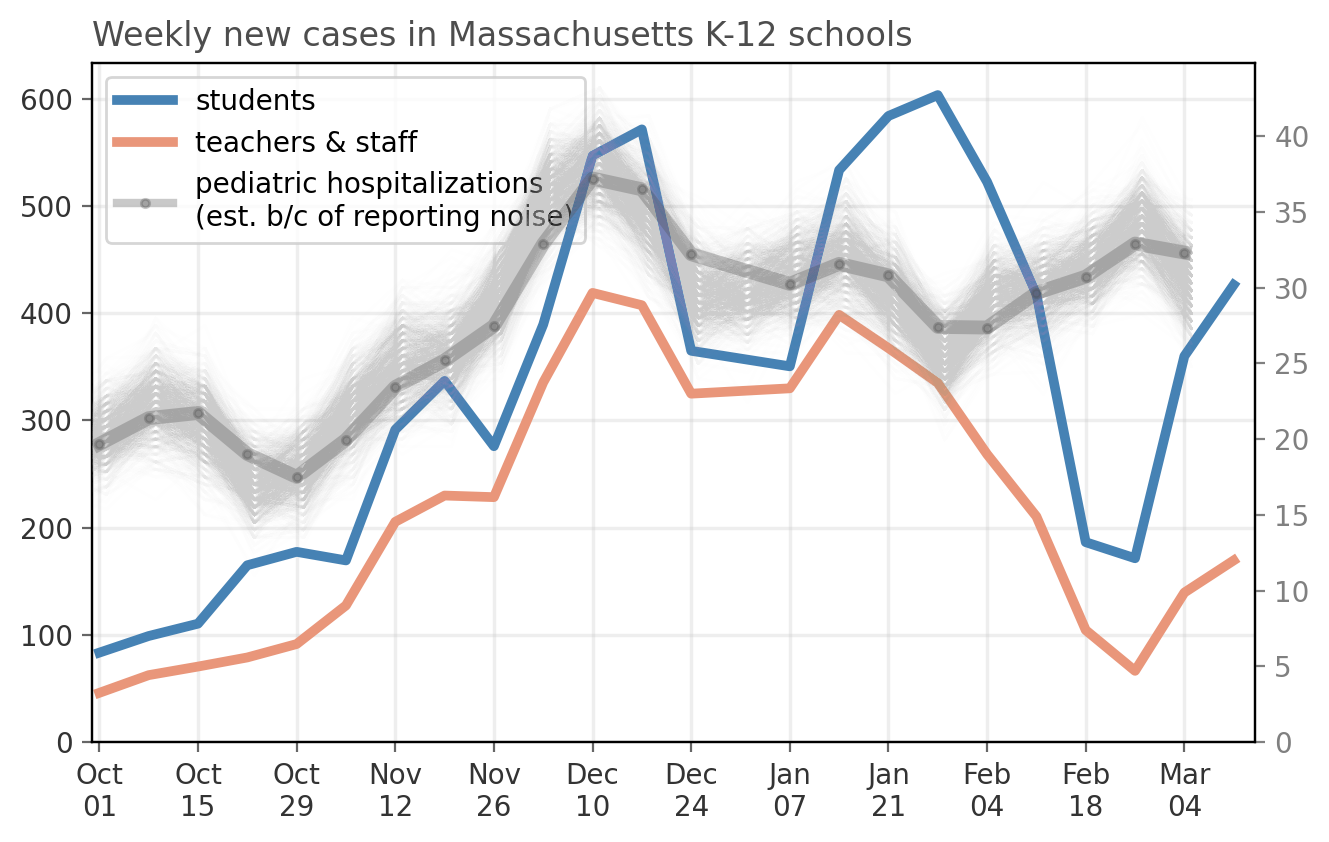

In [31]:
wid = 2
fig, ax = plt.subplots(1,1, figsize=(7.5, 4.5), dpi=200)

cols = ['steelblue','darksalmon']

ax2 = ax.twinx()
child_avg = []
for xi in range(1000):
    ma_hosp = hosp.loc[hosp['state']==st].copy()
    ma_hosp[child_col] = [i if i != -999999.0 else np.random.randint(1,4) for i in ma_hosp[child_col]]

    ma_hosp_g = ma_hosp.groupby(['collection_week']).agg({child_col:np.nansum}).reset_index()
    dates = [i for i in ma_hosp_g['collection_week'].values]

    ax2.plot([date_dict[i] for i in dates],ma_hosp_g[child_col].rolling(window=wid).mean().values,
             color='.8', lw=1, alpha=0.01, marker='',zorder=10)
    child_avg.append(ma_hosp_g[child_col].rolling(window=wid).mean().values)

tmp = ma_hosp_g.merge(DATE_DF.rename(columns={'date':'collection_week'}),
                      how='left', on='collection_week')
tmp['pediatric_hosp'] = np.mean(child_avg,axis=0)
tmp = tmp.rename(columns={'collection_week':'date'})
child_hosp = tmp[['date','week','pediatric_hosp']].copy()
sch_dfg_hosp = sch_dfg.merge(child_hosp[['week','pediatric_hosp']], how='left', on='week')

ax2.plot([date_dict[i] for i in sch_dfg_hosp['date']],
         sch_dfg_hosp['pediatric_hosp'].rolling(window=wid).mean().values,
         color='.3',lw=5,alpha=0.3,marker='.',zorder=11)
ax2.tick_params(labelcolor='.5', color='.5')

ax.plot([date_dict[i] for i in sch_dfg['date']],
        sch_dfg['new_cases_students'].rolling(window=wid).mean().values,
        label='students', lw=3.5, color=cols[0], zorder=100)
ax.plot([date_dict[i] for i in sch_dfg['date']],
        sch_dfg['new_cases_employee'].rolling(window=wid).mean().values,
        label='teachers & staff', lw=3.5, color=cols[1], zorder=100)
ax.plot([-100,-101],[-1,-1],lw=3,color='.3',alpha=0.3,marker='.',
        label='pediatric hospitalizations\n(est. b/c of reporting noise)')

dates = [i for i in date_dict.keys() if i > '2020-09-26'][4::14]
ax.set_xticks([date_dict[i] for i in dates])
ax.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
ax.set_xlim(date_dict[sch_dfg['date'].min()]-1+7,date_dict[sch_dfg['date'].max()]+3)

ax.legend(loc=2)
ax.tick_params(labelcolor='.2', color='.4')
ax.grid(linewidth=1.25,color='.75',alpha=0.25)
ax.set_ylim(0)
ax2.set_ylim(0)

ax.set_title('Weekly new cases in Massachusetts K-12 schools',
             x=0,color='.3',ha='left')

plt.savefig('../figs/pngs/ma_k12_schools_hosp',dpi=425,bbox_inches='tight')
plt.show()

In [32]:
# w = 3.0; h = 2.3
# ncols = 6; nrows = 4
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.15)

# labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
#        'Higher Education', 'Corrections', 'Hospitals', 'Household',
#        'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
#        'Offices', 'Organized\nAthletics/Camps', 'Other',
#        'Other Food\nEstablishments', 'Other Healthcare',
#        'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
#        'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
#        'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

# ncats = contact_df['setting'].nunique()
# cols = plt.cm.tab20b(np.linspace(0,1,ncats))

# for di, dcurr in enumerate(contact_df.sort_values('raw_total_cases',ascending=False)['setting'].unique()):
#     di += 1
#     aa = ax[tups[di]]
#     cti = contact_df.loc[contact_df['setting']==dcurr].copy()
#     cti.loc[cti['raw_new_cases']=='','raw_new_cases'] = 0
#     aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc='w',ec='.2')
#     aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc=cols[di-1],
#            ec='none',alpha=0.3)
    
#     aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
#     aa.grid(linewidth=1.5,color='.75',alpha=0.25)
#     aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
#     aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[1::4]])
#     aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[1::4]])


# aa = ax[tups[0]]
# aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (new cases\nprev. 4 weeks)',
#         ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')

# aa.set_axis_off()


# # plt.savefig('../figs/pngs/ma_outbreak_settings_newcases.png',dpi=425,bbox_inches='tight')

# plt.show()


# w = 3.0; h = 2.3
# ncols = 6; nrows = 4
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.15)

# labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
#        'Higher Education', 'Corrections', 'Hospitals', 'Household',
#        'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
#        'Offices', 'Organized\nAthletics/Camps', 'Other',
#        'Other Food\nEstablishments', 'Other Healthcare',
#        'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
#        'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
#        'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

# ncats = contact_df['setting'].nunique()
# cols = plt.cm.tab20b(np.linspace(0,1,ncats))

# for di, dcurr in enumerate(contact_df.loc[contact_df['data_date']==contact_df['data_date'].max()\
#                                          ].sort_values('raw_new_cases',ascending=False)['setting'].unique()):
#     di += 1
#     aa = ax[tups[di]]
#     fci = '.7'
#     cti = contact_df.loc[contact_df['setting']==dcurr].copy()
#     cti['raw_new_cases'] = np.nan_to_num(cti['raw_new_cases'].astype(float))
#     cti['raw_new_cases'] = cti['raw_new_cases'].rolling(window=2).mean().values
#     if np.mean(cti['raw_new_cases'].values[-2:]>np.mean(cti['raw_new_cases'].values[-4:-2])):
#         fci = 'coral'

#     aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc='w',ec='.2')
#     aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc=fci,
#            ec='none',alpha=0.3)
    
#     aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
#     aa.grid(linewidth=1.5,color='.75',alpha=0.25)
#     aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
#     aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[2::4]])
#     aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[2::4]])


# aa = ax[tups[0]]
# aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (new cases\nprev. 4 weeks)',
#         ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')

# aa.set_axis_off()


# plt.savefig('../figs/pngs/ma_outbreak_settings_newcases2.png',dpi=425,bbox_inches='tight')

# plt.show()

# w = 3.0; h = 2.3
# ncols = 6; nrows = 4
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.15)

# labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
#        'Higher Education', 'Corrections', 'Hospitals', 'Household',
#        'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
#        'Offices', 'Organized\nAthletics/Camps', 'Other',
#        'Other Food\nEstablishments', 'Other Healthcare',
#        'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
#        'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
#        'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

# ncats = contact_df['setting'].nunique()
# cols = plt.cm.tab20b(np.linspace(0,1,ncats))

# for di, dcurr in enumerate(contact_df.sort_values('raw_total_cases',ascending=False)['setting'].unique()):
#     di += 1
#     aa = ax[tups[di]]
#     cti = contact_df.loc[contact_df['setting']==dcurr].copy()
#     cti.loc[cti['raw_new_clusters']=='','raw_new_clusters'] = 0
#     cti.loc[cti['raw_new_cases']=='','raw_new_cases'] = 0
#     cti['raw_new_cases_per'] = cti['raw_new_cases'] / cti['raw_new_clusters'].rolling(window=2).mean()
#     aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases_per'].values,fc='w',ec='.2')
#     aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases_per'].values,fc=cols[di-1],
#            ec='none',alpha=0.3)

#     aa.text(0.025,0.95,labs[dcurr],
#             ha='left', va='top',transform=aa.transAxes, fontsize='x-large',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
#     ym = 0.815
#     if "\n" in labs[dcurr]:
#         ym = 0.675
#     aa.text(0.025,ym,'4wk $average=%.2f$'%(np.mean(cti['raw_new_cases_per'].dropna().values[-4:])),
#             ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

#     aa.grid(linewidth=1.5,color='.75',alpha=0.25)
#     aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
#     aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[1::4]])
#     if labs[dcurr] == 'Corrections':
#         aa.set_ylim(0, 70)
#     else:
#         aa.set_ylim(0, 23)
#     aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[1::4]])


# aa = ax[tups[0]]
# aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (new cases\nper cluster)',
#         ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')

# aa.set_axis_off()

# plt.savefig('../figs/pngs/ma_outbreak_settings_newcases_per.png',dpi=425,bbox_inches='tight')

# plt.show()

# w = 3.0; h = 2.7
# ncols = 7; nrows = 3
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.15)

# labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
#        'Higher Education', 'Corrections', 'Hospitals', 'Household',
#        'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
#        'Offices', 'Organized\nAthletics/Camps', 'Other',
#        'Other Food\nEstablishments', 'Other Healthcare',
#        'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
#        'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
#        'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

# labs = dict(zip(['Hospitals', 'Other Healthcare', 'Long Term Care Facilities', 'Senior Living',
#                  '24/7 Congregate Settings', 'Retail & Services', 'Child Care'],
#                 ['Hospitals', 'Other Healthcare', 'Long Term Care\nFacilities', 'Senior Living',
#                  '24/7 Congregate\nSettings', 'Retail &\nServices', 'Child Care']))

# ncats = len(labs.keys())
# cols = plt.cm.tab20b(np.linspace(0,1,ncats))
# cols = ['teal']*5 + ['peru']*2
# for di, dcurr in enumerate(list(labs.keys())):
#     fci = cols[di]
#     aa = ax[tups[di]]
#     cti = contact_df.loc[contact_df['setting']==dcurr].copy()
#     cti.loc[cti['raw_new_cases']=='','raw_new_cases'] = 0
#     aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc='w',ec='.2')
#     aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc=fci,
#            ec='none',alpha=0.3)
#     aa.bar(list(range(len(cti['raw_new_cases'])))[-4:],cti['raw_new_cases'].values[-4:],fc=fci,
#            ec='none',alpha=0.3)
    
#     aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

# xlimx = max(list(range(len(cti['raw_new_cases']))))+0.5
# dn = di

# for di, dcurr in enumerate(list(labs.keys())):
#     fci = cols[di]
#     di += dn + 1
#     aa = ax[tups[di]]
#     cti = contact_df.loc[contact_df['setting']==dcurr].copy()
#     aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc='w',ec='.2')
#     aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc=fci,
#            ec='none',alpha=0.3)
#     aa.bar(list(range(len(cti['raw_new_clusters'])))[-4:],cti['raw_new_clusters'].values[-4:],fc=fci,
#            ec='none',alpha=0.3)
    
#     aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    
# dn = di

# for di, dcurr in enumerate(list(labs.keys())):
#     fci = cols[di]
#     di += dn + 1
#     aa = ax[tups[di]]
#     cti = contact_df.loc[contact_df['setting']==dcurr].copy()
#     cti['raw_new_cases_per'] = cti['raw_new_cases'] / cti['raw_new_clusters'].rolling(window=2).mean()
#     aa.bar(list(range(len(cti['raw_new_cases_per']))),cti['raw_new_cases_per'].values,fc='w',ec='.2')
#     aa.bar(list(range(len(cti['raw_new_cases_per']))),cti['raw_new_cases_per'].values,fc=fci,
#            ec='none',alpha=0.3)
#     aa.bar(list(range(len(cti['raw_new_cases_per'])))[-4:],cti['raw_new_cases_per'].values[-4:],fc=fci,
#            ec='none',alpha=0.4)

#     aa.text(0.025,0.95,labs[dcurr],
#             ha='left', va='top',transform=aa.transAxes, fontsize='x-large',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
#     ym = 0.85
#     if "\n" in labs[dcurr]:
#         ym = 0.715
#     aa.text(0.025,ym,'$average=%.2f$'%(cti['raw_new_cases_per'].dropna().mean()),
#             ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])


# for ai, a in enumerate(fig.axes):
#     a.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[2::3]])
#     a.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[2::3]])
#     a.set_xlim(4.5, xlimx)
#     a.tick_params(labelcolor='.4',color='.7',labelsize='medium')
#     a.grid(linewidth=1.5,color='.75',alpha=0.25)
#     ylims = a.get_ylim()
#     ydiff = ylims[1] - ylims[0]
#     a.set_ylim(ylims[0], ylims[1]+ydiff*0.32)
#     if ai < 7:
#         a.set_ylim(0, 1950)
#     elif ai >= 7 and ai < 14:
#         a.set_ylim(0, 210)
#     else:
#         a.set_ylim(0, 19)


# ax[(0,0)].set_ylabel('Weekly new cases', color='.2', fontsize=13.5)
# ax[(1,0)].set_ylabel('Weekly new clusters', color='.2', fontsize=13.5)
# ax[(2,0)].set_ylabel('Weekly new cases\nper cluster', color='.2', fontsize=13.5)
# ax[(0,2)].set_title('Healthcare and elderly populations -- priority vaccinations\n'+\
#                     '(Note especially the decline in average cases per cluster)',
#                     color='.4', fontsize=16, y=1.05)
# ax[(0,6)].set_title('Settings with fewer vaccinations so far\n(More constant average cases per cluster)',
#                     color='.4', fontsize=16, x=-0.2, y=1.05)

# # plt.savefig('../figs/pngs/vaccination_vs_nonvaccination.png',dpi=425,bbox_inches='tight')

# plt.show()

In [33]:
# w = 3.0; h = 2.3
# ncols = 6; nrows = 4
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.15)

# labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
#        'Higher Education', 'Corrections', 'Hospitals', 'Household',
#        'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
#        'Offices', 'Organized\nAthletics/Camps', 'Other',
#        'Other Food\nEstablishments', 'Other Healthcare',
#        'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
#        'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
#        'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

# ncats = contact_df['setting'].nunique()
# cols = plt.cm.tab20b(np.linspace(0,1,ncats))

# for di, dcurr in enumerate(contact_df.sort_values('raw_total_cases',ascending=False)['setting'].unique()):
#     di += 1
#     aa = ax[tups[di]]
#     cti = contact_df.loc[contact_df['setting']==dcurr].copy()
#     cti.loc[cti['raw_total_cases']=='','raw_total_cases'] = 0
#     aa.bar(list(range(len(cti['raw_total_cases']))),cti['raw_total_cases'].values,fc='w',ec='.2')
#     aa.bar(list(range(len(cti['raw_total_cases']))),cti['raw_total_cases'].values,fc=cols[di-1],
#            ec='none',alpha=0.3)
    
#     aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
#     aa.grid(linewidth=1.5,color='.75',alpha=0.25)
#     aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
#     aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[1::4]])
#     aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[1::4]])


# aa = ax[tups[0]]
# aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (total cases)', ha='center', va='center',
#             transform=aa.transAxes, color='.4', fontsize='large')

# aa.set_axis_off()


# plt.savefig('../figs/pngs/ma_outbreak_settings_cases.png',dpi=425,bbox_inches='tight')

# plt.show()


# w = 3.0; h = 2.3
# ncols = 6; nrows = 4
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.15)

# labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
#        'Higher Education', 'Corrections', 'Hospitals', 'Household',
#        'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
#        'Offices', 'Organized\nAthletics/Camps', 'Other',
#        'Other Food\nEstablishments', 'Other Healthcare',
#        'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
#        'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
#        'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

# ncats = contact_df['setting'].nunique()
# cols = plt.cm.tab20b(np.linspace(0,1,ncats))

# for di, dcurr in enumerate(contact_df.sort_values('raw_total_cases',ascending=False)['setting'].unique()):
#     di += 1
#     aa = ax[tups[di]]
#     cti = contact_df.loc[contact_df['setting']==dcurr].copy()
#     cti.loc[cti['raw_total_clusters']=='','raw_total_clusters'] = 0
#     aa.bar(list(range(len(cti['raw_total_clusters']))),cti['raw_total_clusters'].values,fc='w',ec='.2')
#     aa.bar(list(range(len(cti['raw_total_clusters']))),cti['raw_total_clusters'].values,fc=cols[di-1],
#            ec='none',alpha=0.3)
    
#     aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
#     aa.grid(linewidth=1.5,color='.75',alpha=0.25)
#     aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
#     aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[1::4]])
#     aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[1::4]])

# aa = ax[tups[0]]
# aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (total clusters)', ha='center', va='center',
#             transform=aa.transAxes, color='.4', fontsize='large')

# aa.set_axis_off()


# plt.savefig('../figs/pngs/ma_outbreak_settings_clusters.png',dpi=425,bbox_inches='tight')

# plt.show()